In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("ConsumptionDataset.csv")

# Clean column names if needed
df.columns = df.columns.str.strip()

# Parse datetime
df['Date Time Served'] = pd.to_datetime(df['Date Time Served'], infer_datetime_format=True, errors='coerce')

# Create date-based features
df['Date'] = df['Date Time Served'].dt.date
df['Year'] = df['Date Time Served'].dt.year
df['Month'] = df['Date Time Served'].dt.month
df['Weekday'] = df['Date Time Served'].dt.day_name()

# Check missing values
print("Missing Values:")
print(df.isnull().sum())

# Check for negative values
print("\nNegative Values in Key Columns:")
num_cols = ['Opening Balance (ml)', 'Purchase (ml)', 'Consumed (ml)', 'Closing Balance (ml)']
print((df[num_cols] < 0).sum())

# Inventory flow consistency check
df['Expected Closing'] = df['Opening Balance (ml)'] + df['Purchase (ml)'] - df['Consumed (ml)']
df['Discrepancy'] = df['Closing Balance (ml)'] - df['Expected Closing']

# Print a few inconsistent rows (with more than minimal discrepancy)
inconsistencies = df[abs(df['Discrepancy']) > 1e-2]
print("\nSample inconsistent rows (if any):")
print(inconsistencies[['Date Time Served', 'Opening Balance (ml)', 'Purchase (ml)', 'Consumed (ml)', 'Closing Balance (ml)', 'Expected Closing', 'Discrepancy']].head())

# Drop rows with missing datetime and make a safe copy
df_cleaned = df.dropna(subset=['Date Time Served']).copy()

# Summary of cleaning
print("\nCleaning Summary:")
print(f"Original Rows: {len(df)}")
print(f"Rows After Cleaning: {len(df_cleaned)}")
print(f"Dropped Rows: {len(df) - len(df_cleaned)}")

# View structure of cleaned data
print(df_cleaned.info())

# View cleaned dataset
df_cleaned.head()

Missing Values:
Date Time Served        3954
Bar Name                   0
Alcohol Type               0
Brand Name                 0
Opening Balance (ml)       0
Purchase (ml)              0
Consumed (ml)              0
Closing Balance (ml)       0
Date                    3954
Year                    3954
Month                   3954
Weekday                 3954
dtype: int64

Negative Values in Key Columns:
Opening Balance (ml)    0
Purchase (ml)           0
Consumed (ml)           0
Closing Balance (ml)    0
dtype: int64

Sample inconsistent rows (if any):
       Date Time Served  Opening Balance (ml)  Purchase (ml)  Consumed (ml)  \
42  2023-01-03 20:00:00                826.20           0.00         227.73   
58  2023-01-04 10:45:00               2300.00           0.00         349.22   
99  2023-01-06 13:10:00               1427.79           0.00         248.86   
125 2023-01-07 14:01:00               2510.00           0.00         494.68   
143 2023-01-08 14:46:00                126

<ipython-input-1-4ba9223cf700>:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date Time Served'] = pd.to_datetime(df['Date Time Served'], infer_datetime_format=True, errors='coerce')


,Date Time Served,Bar Name,Alcohol Type,Brand Name,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml),Date,Year,Month,Weekday,Expected Closing,Discrepancy
0,2023-01-01 19:35:00,Smith's Bar,Rum,Captain Morgan,2555.04,1824.84,0.0,4379.88,2023-01-01,2023.0,1.0,Sunday,4379.88,0.0
1,2023-01-01 10:07:00,Smith's Bar,Wine,Yellow Tail,1344.37,0.00,0.0,1344.37,2023-01-01,2023.0,1.0,Sunday,1344.37,0.0
2,2023-01-01 11:26:00,Johnson's Bar,Vodka,Grey Goose,1034.28,0.00,0.0,1034.28,2023-01-01,2023.0,1.0,Sunday,1034.28,0.0
3,2023-01-01 13:53:00,Johnson's Bar,Beer,Coors,2194.53,0.00,0.0,2194.53,2023-01-01,2023.0,1.0,Sunday,2194.53,0.0
4,2023-01-01 22:28:00,Johnson's Bar,Wine,Yellow Tail,1020.90,0.00,0.0,1020.90,2023-01-01,2023.0,1.0,Sunday,1020.90,0.0


In [2]:
# Aggregate consumption per day per (Bar, Brand)
daily_consumption = df_cleaned.groupby(['Bar Name', 'Brand Name', 'Date'], as_index=False)['Consumed (ml)'].sum()

# Rename for clarity
daily_consumption.rename(columns={'Consumed (ml)': 'Daily Consumption (ml)'}, inplace=True)

# date for time series modeling
daily_consumption.sort_values(by=['Bar Name', 'Brand Name', 'Date'], inplace=True)

# Add time-based features
daily_consumption['Date'] = pd.to_datetime(daily_consumption['Date'])
daily_consumption['Year'] = daily_consumption['Date'].dt.year
daily_consumption['Month'] = daily_consumption['Date'].dt.month
daily_consumption['Weekday'] = daily_consumption['Date'].dt.day_name()
daily_consumption['DayOfWeek'] = daily_consumption['Date'].dt.dayofweek

# Add rolling consumption mean (7-day)
daily_consumption['Rolling_7d'] = (
    daily_consumption.groupby(['Bar Name', 'Brand Name'])['Daily Consumption (ml)']
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)

# Preview final aggregated and feature-engineered data
daily_consumption.head()

,Bar Name,Brand Name,Date,Daily Consumption (ml),Year,Month,Weekday,DayOfWeek,Rolling_7d
0,Anderson's Bar,Absolut,2023-01-02,118.62,2023,1,Monday,0,118.620000
1,Anderson's Bar,Absolut,2023-01-05,463.20,2023,1,Thursday,3,290.910000
2,Anderson's Bar,Absolut,2023-01-06,453.02,2023,1,Friday,4,344.946667
3,Anderson's Bar,Absolut,2023-01-08,275.08,2023,1,Sunday,6,327.480000
4,Anderson's Bar,Absolut,2023-01-11,0.00,2023,1,Wednesday,2,261.984000


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/240y1h29.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/hgjhcwle.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21735', 'data', 'file=/tmp/tmpci_91brs/240y1h29.json', 'init=/tmp/tmpci_91brs/hgjhcwle.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model1qlb4em7/prophet_model-20250525134559.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:45:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:45:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


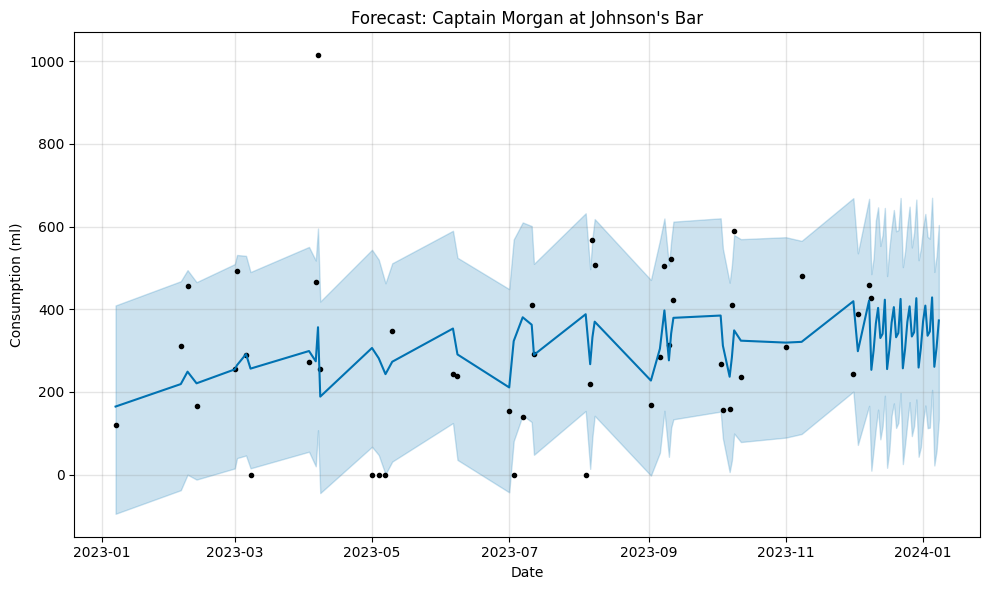

In [3]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Sample pair
bar_sample = "Johnson's Bar"
brand_sample = "Captain Morgan"

# Filter the data
sample_df = daily_consumption[
    (daily_consumption['Bar Name'] == bar_sample) &
    (daily_consumption['Brand Name'] == brand_sample)
].copy()

# Prepare data for Prophet
prophet_df = sample_df[['Date', 'Daily Consumption (ml)']].rename(
    columns={'Date': 'ds', 'Daily Consumption (ml)': 'y'}
)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Initialize and fit the model
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(prophet_df)

# Create future dates
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title(f"Forecast: {brand_sample} at {bar_sample}")
plt.xlabel("Date")
plt.ylabel("Consumption (ml)")
plt.tight_layout()
plt.show()

In [4]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Prepare storage
all_forecasts = []

# Valid pairs with sufficient history
pair_counts = daily_consumption.groupby(['Bar Name', 'Brand Name']).size().reset_index(name='Count')
valid_pairs = pair_counts[pair_counts['Count'] > 20][['Bar Name', 'Brand Name']]

# Forecast for each pair
for index, row in tqdm(valid_pairs.iterrows(), total=valid_pairs.shape[0], desc="Forecasting"):
    bar = row['Bar Name']
    brand = row['Brand Name']
    print(f"Processing: {bar} - {brand}")

    subset = daily_consumption[
        (daily_consumption['Bar Name'] == bar) &
        (daily_consumption['Brand Name'] == brand)
    ].copy()

    prophet_df = subset[['Date', 'Daily Consumption (ml)']].rename(columns={
        'Date': 'ds',
        'Daily Consumption (ml)': 'y'
    })
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    try:
        model = Prophet(daily_seasonality=True, weekly_seasonality=True)
        model.fit(prophet_df)

        future = model.make_future_dataframe(periods=30)
        forecast = model.predict(future)

        future_forecast = forecast.tail(30)
        avg_demand = future_forecast['yhat'].mean()
        high_demand = future_forecast['yhat_upper'].quantile(0.95)

        all_forecasts.append({
            'Bar Name': bar,
            'Brand Name': brand,
            'Forecasted Avg Demand (30d)': round(avg_demand, 2),
            'Forecasted High Demand (95th percentile)': round(high_demand, 2)
        })
    except Exception as e:
        print(f"Error for {bar} - {brand}: {e}")

forecast_results_df = pd.DataFrame(all_forecasts)
forecast_results_df.head()

# Save cleaned data
daily_consumption.to_csv("data.csv", index=False)

Forecasting:   0%|          | 0/83 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/k8m71ytk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/68i7d7ls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82028', 'data', 'file=/tmp/tmpci_91brs/k8m71ytk.json', 'init=/tmp/tmpci_91brs/68i7d7ls.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modele6k5141f/prophet_model-20250525134600.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:   1%|          | 1/83 [00:00<00:15,  5.19it/s]INFO:prophet:Disabling yearly

Processing: Anderson's Bar - Absolut
Processing: Anderson's Bar - Bacardi


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7xtbe27u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/wdf988hj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32568', 'data', 'file=/tmp/tmpci_91brs/7xtbe27u.json', 'init=/tmp/tmpci_91brs/wdf988hj.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelz19tzxm_/prophet_model-20250525134600.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:   2%|▏         | 2/83 [00:00<00:14,  5.60it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/48apeo_d.json
DEBUG:cmdstanpy:i

Processing: Anderson's Bar - Barefoot


Forecasting:   4%|▎         | 3/83 [00:00<00:16,  4.83it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fgssxxgo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/l2bu4krz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50342', 'data', 'file=/tmp/tmpci_91brs/fgssxxgo.json', 'init=/tmp/tmpci_91brs/l2bu4krz.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeljdjxmn8k/prophet_model-20250525134601.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forec

Processing: Anderson's Bar - Captain Morgan
Processing: Anderson's Bar - Coors


13:46:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:   6%|▌         | 5/83 [00:00<00:13,  5.60it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7l4yznfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/x6kwe849.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85306', 'data', 'file=/tmp/tmpci_91brs/7l4yznfg.json', 'init=/tmp/tmpci_91brs/x6kwe849.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelf7mz1vzz/prophet_model-20250525134601.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46

Processing: Anderson's Bar - Grey Goose
Processing: Anderson's Bar - Heineken


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/tfnlfkum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rg_cnu5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31124', 'data', 'file=/tmp/tmpci_91brs/tfnlfkum.json', 'init=/tmp/tmpci_91brs/rg_cnu5n.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelxu2d3n76/prophet_model-20250525134601.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:   8%|▊         | 7/83 [00:01<00:12,  5.86it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG

Processing: Anderson's Bar - Jack Daniels
Processing: Anderson's Bar - Jameson


13:46:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  11%|█         | 9/83 [00:01<00:13,  5.45it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/343eoq9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/skq3zld5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35337', 'data', 'file=/tmp/tmpci_91brs/343eoq9d.json', 'init=/tmp/tmpci_91brs/skq3zld5.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelupw0g9ka/prophet_model-20250525134602.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1]

Processing: Anderson's Bar - Jim Beam
Processing: Anderson's Bar - Malibu


13:46:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  13%|█▎        | 11/83 [00:01<00:12,  5.97it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/udgfawv9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zd0bf1nj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80143', 'data', 'file=/tmp/tmpci_91brs/udgfawv9.json', 'init=/tmp/tmpci_91brs/zd0bf1nj.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelfxrl2tje/prophet_model-20250525134602.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Anderson's Bar - Miller
Processing: Anderson's Bar - Smirnoff


13:46:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  16%|█▌        | 13/83 [00:02<00:13,  5.22it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/amm6e4iv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jzv75ekk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=960', 'data', 'file=/tmp/tmpci_91brs/amm6e4iv.json', 'init=/tmp/tmpci_91brs/jzv75ekk.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model8w3gxm_v/prophet_model-20250525134602.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:

Processing: Anderson's Bar - Sutter Home


Forecasting:  17%|█▋        | 14/83 [00:02<00:13,  4.97it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/yovl7917.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/90kfegh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21598', 'data', 'file=/tmp/tmpci_91brs/yovl7917.json', 'init=/tmp/tmpci_91brs/90kfegh_.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modell5l2miwb/prophet_model-20250525134603.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing: Anderson's Bar - Yellow Tail


Forecasting:  18%|█▊        | 15/83 [00:02<00:14,  4.59it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/nqv7ejk7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2y2h42aq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80471', 'data', 'file=/tmp/tmpci_91brs/nqv7ejk7.json', 'init=/tmp/tmpci_91brs/2y2h42aq.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelz6sfiuoy/prophet_model-20250525134603.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing: Brown's Bar - Absolut


Forecasting:  19%|█▉        | 16/83 [00:03<00:14,  4.49it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/xocz2e0a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/k8ujicae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74451', 'data', 'file=/tmp/tmpci_91brs/xocz2e0a.json', 'init=/tmp/tmpci_91brs/k8ujicae.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeljlmwgwqu/prophet_model-20250525134603.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing: Brown's Bar - Bacardi


Forecasting:  20%|██        | 17/83 [00:03<00:15,  4.22it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/_bq3kebl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/g9a26r9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77856', 'data', 'file=/tmp/tmpci_91brs/_bq3kebl.json', 'init=/tmp/tmpci_91brs/g9a26r9b.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelixjeqx63/prophet_model-20250525134603.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing: Brown's Bar - Barefoot


Forecasting:  22%|██▏       | 18/83 [00:03<00:15,  4.13it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ghl_vp0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/w2r6vrw_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25757', 'data', 'file=/tmp/tmpci_91brs/ghl_vp0m.json', 'init=/tmp/tmpci_91brs/w2r6vrw_.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeltpteiw4_/prophet_model-20250525134604.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Fore

Processing: Brown's Bar - Captain Morgan
Processing: Brown's Bar - Grey Goose


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/34ume1sb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fxdm84c_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18885', 'data', 'file=/tmp/tmpci_91brs/34ume1sb.json', 'init=/tmp/tmpci_91brs/fxdm84c_.json', 'output', 'file=/tmp/tmpci_91brs/prophet_models4o4ldpl/prophet_model-20250525134604.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  24%|██▍       | 20/83 [00:04<00:14,  4.22it/s]INFO

Processing: Brown's Bar - Jack Daniels


13:46:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  25%|██▌       | 21/83 [00:04<00:15,  3.94it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2m1sk4c6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vywdzo_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17971', 'data', 'file=/tmp/tmpci_91brs/2m1sk4c6.json', 'init=/tmp/tmpci_91brs/vywdzo_h.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelxmwwqtqo/prophet_model-20250525134604.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Brown's Bar - Jameson


Forecasting:  27%|██▋       | 22/83 [00:04<00:15,  3.92it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ao3bklyx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/lzmbqdde.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36422', 'data', 'file=/tmp/tmpci_91brs/ao3bklyx.json', 'init=/tmp/tmpci_91brs/lzmbqdde.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeljzr7phx5/prophet_model-20250525134605.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing: Brown's Bar - Jim Beam


Forecasting:  28%|██▊       | 23/83 [00:04<00:15,  3.83it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/xl3a5xog.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/93kjx61u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99966', 'data', 'file=/tmp/tmpci_91brs/xl3a5xog.json', 'init=/tmp/tmpci_91brs/93kjx61u.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_hldq98w/prophet_model-20250525134605.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing: Brown's Bar - Malibu


Forecasting:  29%|██▉       | 24/83 [00:05<00:14,  4.07it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/75y1ffb1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/242xmyhu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25326', 'data', 'file=/tmp/tmpci_91brs/75y1ffb1.json', 'init=/tmp/tmpci_91brs/242xmyhu.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeliramn9dg/prophet_model-20250525134605.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Fore

Processing: Brown's Bar - Miller
Processing: Brown's Bar - Smirnoff


13:46:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  31%|███▏      | 26/83 [00:05<00:11,  4.92it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7bxkd4m6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/596v_jdx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45224', 'data', 'file=/tmp/tmpci_91brs/7bxkd4m6.json', 'init=/tmp/tmpci_91brs/596v_jdx.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model4kt4gmkd/prophet_model-20250525134605.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Brown's Bar - Sutter Home
Processing: Brown's Bar - Yellow Tail


13:46:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  34%|███▎      | 28/83 [00:05<00:10,  5.30it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fmtvk716.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/b2yme0wj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71044', 'data', 'file=/tmp/tmpci_91brs/fmtvk716.json', 'init=/tmp/tmpci_91brs/b2yme0wj.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelx6bgi7nh/prophet_model-20250525134606.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing: Johnson's Bar - Absolut


13:46:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  35%|███▍      | 29/83 [00:06<00:11,  4.53it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/nzsu1e3b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/uzco4h6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67883', 'data', 'file=/tmp/tmpci_91brs/nzsu1e3b.json', 'init=/tmp/tmpci_91brs/uzco4h6t.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model85zy7ifh/prophet_model-20250525134606.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Johnson's Bar - Barefoot
Processing: Johnson's Bar - Captain Morgan


13:46:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  37%|███▋      | 31/83 [00:06<00:10,  5.18it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/_hhqrg9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zipmgxts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13235', 'data', 'file=/tmp/tmpci_91brs/_hhqrg9h.json', 'init=/tmp/tmpci_91brs/zipmgxts.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model8t6891va/prophet_model-20250525134606.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Johnson's Bar - Coors
Processing: Johnson's Bar - Grey Goose


13:46:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  40%|███▉      | 33/83 [00:06<00:09,  5.24it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/3fm_lrz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/nmu0cain.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80422', 'data', 'file=/tmp/tmpci_91brs/3fm_lrz_.json', 'init=/tmp/tmpci_91brs/nmu0cain.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model7wbhp0ra/prophet_model-20250525134607.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Johnson's Bar - Heineken
Processing: Johnson's Bar - Jameson


13:46:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  42%|████▏     | 35/83 [00:07<00:08,  5.77it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/lpcl0ryb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rs23816a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26888', 'data', 'file=/tmp/tmpci_91brs/lpcl0ryb.json', 'init=/tmp/tmpci_91brs/rs23816a.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelh1nl72r0/prophet_model-20250525134607.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Johnson's Bar - Jim Beam


Forecasting:  43%|████▎     | 36/83 [00:07<00:08,  5.22it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/0o_1sb74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/o6yh814u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22778', 'data', 'file=/tmp/tmpci_91brs/0o_1sb74.json', 'init=/tmp/tmpci_91brs/o6yh814u.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_gq1293g/prophet_model-20250525134607.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Fore

Processing: Johnson's Bar - Malibu
Processing: Johnson's Bar - Miller


13:46:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  46%|████▌     | 38/83 [00:07<00:07,  5.82it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/3c_o21hr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ae1668bw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7486', 'data', 'file=/tmp/tmpci_91brs/3c_o21hr.json', 'init=/tmp/tmpci_91brs/ae1668bw.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model6093wkv0/prophet_model-20250525134608.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46

Processing: Johnson's Bar - Smirnoff


Forecasting:  47%|████▋     | 39/83 [00:07<00:08,  5.09it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/w15wnv3u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/a5xh88o5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45977', 'data', 'file=/tmp/tmpci_91brs/w15wnv3u.json', 'init=/tmp/tmpci_91brs/a5xh88o5.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelorf0h00p/prophet_model-20250525134608.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Fore

Processing: Johnson's Bar - Sutter Home
Processing: Johnson's Bar - Yellow Tail


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/oni745a9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/1ec9o5_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35552', 'data', 'file=/tmp/tmpci_91brs/oni745a9.json', 'init=/tmp/tmpci_91brs/1ec9o5_q.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modely6e7vzd9/prophet_model-20250525134608.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  49%|████▉     | 41/83 [00:08<00:08,  5.24it/s]INFO

Processing: Smith's Bar - Absolut
Processing: Smith's Bar - Barefoot


13:46:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  52%|█████▏    | 43/83 [00:08<00:07,  5.34it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/yun7y4ki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/78_lsu9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41177', 'data', 'file=/tmp/tmpci_91brs/yun7y4ki.json', 'init=/tmp/tmpci_91brs/78_lsu9r.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelz5tnw0i8/prophet_model-20250525134609.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Smith's Bar - Captain Morgan
Processing: Smith's Bar - Coors


13:46:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  54%|█████▍    | 45/83 [00:08<00:06,  6.01it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7wos6176.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ny5x56ak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55982', 'data', 'file=/tmp/tmpci_91brs/7wos6176.json', 'init=/tmp/tmpci_91brs/ny5x56ak.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelcicf0osu/prophet_model-20250525134609.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Smith's Bar - Grey Goose
Processing: Smith's Bar - Jack Daniels


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/aqin67q6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/j9qopjnf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41902', 'data', 'file=/tmp/tmpci_91brs/aqin67q6.json', 'init=/tmp/tmpci_91brs/j9qopjnf.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model1eqzre93/prophet_model-20250525134609.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  57%|█████▋    | 47/83 [00:09<00:05,  6.04it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBU

Processing: Smith's Bar - Jameson
Processing: Smith's Bar - Jim Beam


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/d5q03sbz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7dx6bd3u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18561', 'data', 'file=/tmp/tmpci_91brs/d5q03sbz.json', 'init=/tmp/tmpci_91brs/7dx6bd3u.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelu24i8uoa/prophet_model-20250525134609.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  59%|█████▉    | 49/83 [00:09<00:05,  5.82it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBU

Processing: Smith's Bar - Malibu
Processing: Smith's Bar - Miller


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12629', 'data', 'file=/tmp/tmpci_91brs/kmp4x4c2.json', 'init=/tmp/tmpci_91brs/y_e3lcxd.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelxwu1b7hr/prophet_model-20250525134610.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  61%|██████▏   | 51/83 [00:09<00:05,  5.90it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/6sob1x5f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jsp9njw4.json
DEBU

Processing: Smith's Bar - Smirnoff
Processing: Smith's Bar - Sutter Home


INFO:cmdstanpy:Chain [1] start processing
13:46:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  64%|██████▍   | 53/83 [00:10<00:05,  5.95it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/y_jdoxq5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/lvftjw_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52829', 'data', 'file=/tmp/tmpci_91brs/y_jdoxq5.json', 'init=/tmp/tmpci_91brs/lvftjw_x.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelevny8dob/prophet_model-20250525134610.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:10 - cmdstanpy - INFO - Chain [

Processing: Smith's Bar - Yellow Tail
Processing: Taylor's Bar - Absolut


13:46:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  66%|██████▋   | 55/83 [00:10<00:04,  6.17it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/65c5brrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/lau75lv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12179', 'data', 'file=/tmp/tmpci_91brs/65c5brrd.json', 'init=/tmp/tmpci_91brs/lau75lv9.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_2vk_mzo/prophet_model-20250525134610.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:4

Processing: Taylor's Bar - Bacardi
Processing: Taylor's Bar - Barefoot


13:46:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  69%|██████▊   | 57/83 [00:10<00:04,  6.00it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/h92i6sjj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jag9wd_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11166', 'data', 'file=/tmp/tmpci_91brs/h92i6sjj.json', 'init=/tmp/tmpci_91brs/jag9wd_w.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelkw3ffpby/prophet_model-20250525134611.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Taylor's Bar - Captain Morgan
Processing: Taylor's Bar - Coors


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/35_s505t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/pnjc2ntc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4044', 'data', 'file=/tmp/tmpci_91brs/35_s505t.json', 'init=/tmp/tmpci_91brs/pnjc2ntc.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeldqt1f1iz/prophet_model-20250525134611.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  71%|███████   | 59/83 [00:11<00:04,  5.94it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/r5ondqxe.json
DEBUG:cmdstanpy:i

Processing: Taylor's Bar - Grey Goose


Forecasting:  72%|███████▏  | 60/83 [00:11<00:04,  5.41it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/lw0s4g1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/_c51c2bw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23825', 'data', 'file=/tmp/tmpci_91brs/lw0s4g1q.json', 'init=/tmp/tmpci_91brs/_c51c2bw.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelslfc1y53/prophet_model-20250525134611.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Fore

Processing: Taylor's Bar - Heineken
Processing: Taylor's Bar - Jack Daniels


13:46:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  75%|███████▍  | 62/83 [00:11<00:03,  5.66it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/llyenv7k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/kcxkm6x1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88743', 'data', 'file=/tmp/tmpci_91brs/llyenv7k.json', 'init=/tmp/tmpci_91brs/kcxkm6x1.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelhgjf6bsg/prophet_model-20250525134612.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Taylor's Bar - Jameson
Processing: Taylor's Bar - Jim Beam


13:46:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  77%|███████▋  | 64/83 [00:12<00:03,  5.50it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/kq_6azhc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/6doxe4k0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5125', 'data', 'file=/tmp/tmpci_91brs/kq_6azhc.json', 'init=/tmp/tmpci_91brs/6doxe4k0.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model765y3snp/prophet_model-20250525134612.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46

Processing: Taylor's Bar - Malibu


Forecasting:  78%|███████▊  | 65/83 [00:12<00:03,  5.18it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/_bz_c7v5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/clnm6afw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94045', 'data', 'file=/tmp/tmpci_91brs/_bz_c7v5.json', 'init=/tmp/tmpci_91brs/clnm6afw.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeluwblcwf_/prophet_model-20250525134612.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Fore

Processing: Taylor's Bar - Miller
Processing: Taylor's Bar - Smirnoff


13:46:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  81%|████████  | 67/83 [00:12<00:02,  5.55it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/j3myqg48.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vt5vprjc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57160', 'data', 'file=/tmp/tmpci_91brs/j3myqg48.json', 'init=/tmp/tmpci_91brs/vt5vprjc.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelgz9oqam5/prophet_model-20250525134613.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Taylor's Bar - Sutter Home
Processing: Taylor's Bar - Yellow Tail


13:46:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  83%|████████▎ | 69/83 [00:13<00:02,  5.80it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2f8qahu3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/33b2hob2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72015', 'data', 'file=/tmp/tmpci_91brs/2f8qahu3.json', 'init=/tmp/tmpci_91brs/33b2hob2.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelbc8_1h82/prophet_model-20250525134613.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Thomas's Bar - Absolut
Processing: Thomas's Bar - Bacardi


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/f_ad7fqs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/bjc3lx22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65306', 'data', 'file=/tmp/tmpci_91brs/f_ad7fqs.json', 'init=/tmp/tmpci_91brs/bjc3lx22.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelfemnphiu/prophet_model-20250525134613.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  86%|████████▌ | 71/83 [00:13<00:02,  5.43it/s]INFO

Processing: Thomas's Bar - Barefoot
Processing: Thomas's Bar - Budweiser


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/l9toh8ht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/pr6kf0o7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68699', 'data', 'file=/tmp/tmpci_91brs/l9toh8ht.json', 'init=/tmp/tmpci_91brs/pr6kf0o7.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelhkh_cu3d/prophet_model-20250525134614.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  88%|████████▊ | 73/83 [00:13<00:01,  5.77it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/o0gqfb_i.json
DEBUG:cmdstanpy:

Processing: Thomas's Bar - Captain Morgan


Forecasting:  89%|████████▉ | 74/83 [00:14<00:01,  5.06it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ocxpytas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/0vtdqh96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5476', 'data', 'file=/tmp/tmpci_91brs/ocxpytas.json', 'init=/tmp/tmpci_91brs/0vtdqh96.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelkdo29edk/prophet_model-20250525134614.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  90%|█████████ | 75/83 [00:14<00:01,  5.04it/s]INFO:prophet:Disabli

Processing: Thomas's Bar - Grey Goose
Processing: Thomas's Bar - Jack Daniels


INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/51xqlz2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2xbrnxkj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3754', 'data', 'file=/tmp/tmpci_91brs/51xqlz2b.json', 'init=/tmp/tmpci_91brs/2xbrnxkj.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model4l81fb4k/prophet_model-20250525134614.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  92%|█████████▏| 76/83 [00:14<00:01,  5.18it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:

Processing: Thomas's Bar - Jameson
Processing: Thomas's Bar - Jim Beam


13:46:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  94%|█████████▍| 78/83 [00:14<00:00,  5.63it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/04l9n77v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ttjao9c3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72672', 'data', 'file=/tmp/tmpci_91brs/04l9n77v.json', 'init=/tmp/tmpci_91brs/ttjao9c3.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelj5op1hk2/prophet_model-20250525134615.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Thomas's Bar - Malibu
Processing: Thomas's Bar - Miller


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/iv6bcv6e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rigbivee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26509', 'data', 'file=/tmp/tmpci_91brs/iv6bcv6e.json', 'init=/tmp/tmpci_91brs/rigbivee.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelut9e3hy9/prophet_model-20250525134615.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  96%|█████████▋| 80/83 [00:15<00:00,  5.54it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBU

Processing: Thomas's Bar - Smirnoff


13:46:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:  98%|█████████▊| 81/83 [00:15<00:00,  4.61it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zaz9pnl1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vhi2ki14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20318', 'data', 'file=/tmp/tmpci_91brs/zaz9pnl1.json', 'init=/tmp/tmpci_91brs/vhi2ki14.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelahrre18v/prophet_model-20250525134615.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:4

Processing: Thomas's Bar - Sutter Home


Forecasting:  99%|█████████▉| 82/83 [00:15<00:00,  4.41it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/unb1ueoc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/senb_l_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14452', 'data', 'file=/tmp/tmpci_91brs/unb1ueoc.json', 'init=/tmp/tmpci_91brs/senb_l_n.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelaz1w8cdz/prophet_model-20250525134616.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing: Thomas's Bar - Yellow Tail


13:46:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting: 100%|██████████| 83/83 [00:15<00:00,  5.20it/s]


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Count unique days per (Bar, Brand) pair using the correct dataframe name and columns
# Use 'daily_consumption' dataframe as it already has daily aggregated data and correct column names
pair_counts = daily_consumption.groupby(['Bar Name', 'Brand Name'])['Date'].nunique().reset_index()
pair_counts.columns = ['Bar Name', 'Brand Name', 'Unique Days']

# Keep only pairs with at least 20 unique days
eval_pairs = pair_counts[pair_counts['Unique Days'] >= 20]

# Use all valid pairs (no sampling)
sampled_pairs = eval_pairs.copy()

evaluation_results = []

for _, row in sampled_pairs.iterrows():
    bar = row['Bar Name']
    brand = row['Brand Name']

    # Filter the daily_consumption dataframe for the current pair
    pair_data = daily_consumption[(daily_consumption['Bar Name'] == bar) & (daily_consumption['Brand Name'] == brand)].copy()

    # Rename columns for Prophet
    prophet_data = pair_data[['Date', 'Daily Consumption (ml)']].rename(columns={'Date': 'ds', 'Daily Consumption (ml)': 'y'})

    # Ensure 'ds' is datetime type
    prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])

    # Train-test split: last 7 days as test
    # Ensure there are enough rows before splitting
    if len(prophet_data) < 14 + 7: # Need at least 14 for training + 7 for test
         print(f"Skipping {bar} - {brand}: Not enough data ({len(prophet_data)} days) for training and testing.")
         continue

    train = prophet_data.iloc[:-7]
    test = prophet_data.iloc[-7:]

    # Skip if not enough training data for Prophet
    if len(train) < 2: # Prophet needs at least 2 data points
         print(f"Skipping {bar} - {brand}: Not enough training data ({len(train)} days) for Prophet.")
         continue

    try:
        # Fit Prophet
        model = Prophet()
        model.fit(train)

        # Forecast 7 days ahead
        future = model.make_future_dataframe(periods=len(test), freq='D') # Make future dataframe length of test set
        forecast = model.predict(future)

        # Merge forecast with test set based on the date ('ds' in forecast, 'ds' in test)
        merged = test.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

        # Skip if not enough matching test data
        if len(merged) < 3: # Need at least 3 overlapping points for meaningful metrics
             print(f"Skipping {bar} - {brand}: Only {len(merged)} overlapping test points.")
             continue

        # Metrics
        actual = merged['y']
        predicted = merged['yhat']

        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))

        # Avoid divide-by-zero in MAPE
        mape = np.nan # Initialize mape as NaN
        if (actual != 0).any(): # Only calculate MAPE if there is at least one non-zero actual value
             # Replace 0s in actual with NaN for the division, then take mean, and handle NaN if all actuals were 0
             mape = (abs((actual - predicted) / actual.replace(0, np.nan))).mean() * 100

        evaluation_results.append({
            'Bar Name': bar,
            'Brand Name': brand,
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'MAPE (%)': round(mape, 2) if not np.isnan(mape) else np.nan, # Handle NaN if MAPE couldn't be calculated
            'Test Samples': len(actual) # Number of actual test samples used for metrics
        })

    except Exception as e:
        print(f"Error for {bar} - {brand}: {e}")

# Convert to DataFrame
eval_df = pd.DataFrame(evaluation_results)

# Display
print("\nEvaluation Results:")
display(eval_df.head(10))

eval_df.to_csv("forecast_evaluation_metrics.csv", index=False)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/u8_w1_ys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/t1xcjphw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74043', 'data', 'file=/tmp/tmpci_91brs/u8_w1_ys.json', 'init=/tmp/tmpci_91brs/t1xcjphw.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model0qc7nvi7/prophet_model-20250525134617.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Skipping Anderson's Bar - Absolut: Only 0 overlapping test points.
Skipping Anderson's Bar - Bacardi: Only 1 overlapping test points.


INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2zxa5pml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/79ol2gpf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6565', 'data', 'file=/tmp/tmpci_91brs/2zxa5pml.json', 'init=/tmp/tmpci_91brs/79ol2gpf.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_q6udgis/prophet_model-20250525134618.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_

Skipping Anderson's Bar - Barefoot: Only 1 overlapping test points.
Skipping Anderson's Bar - Captain Morgan: Only 0 overlapping test points.


13:46:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/1bw45lw7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/m8j6qhyl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65869', 'data', 'file=/tmp/tmpci_91brs/1bw45lw7.json', 'init=/tmp/tmpci_91brs/m8j6qhyl.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeloe64wo18/prophet_model-20250525134618.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Anderson's Bar - Coors: Only 0 overlapping test points.
Skipping Anderson's Bar - Grey Goose: Only 1 overlapping test points.


13:46:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/cvtr65n7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/x36w9s76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62818', 'data', 'file=/tmp/tmpci_91brs/cvtr65n7.json', 'init=/tmp/tmpci_91brs/x36w9s76.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelp2utg6n_/prophet_model-20250525134619.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Anderson's Bar - Heineken: Only 1 overlapping test points.
Skipping Anderson's Bar - Jack Daniels: Only 1 overlapping test points.


13:46:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vj951okh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/65le7are.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78992', 'data', 'file=/tmp/tmpci_91brs/vj951okh.json', 'init=/tmp/tmpci_91brs/65le7are.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelxosvpcp9/prophet_model-20250525134619.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Anderson's Bar - Jameson: Only 1 overlapping test points.
Skipping Anderson's Bar - Jim Beam: Only 0 overlapping test points.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ium6ng6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/1afkoly2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59487', 'data', 'file=/tmp/tmpci_91brs/ium6ng6p.json', 'init=/tmp/tmpci_91brs/1afkoly2.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelytpmr2fs/prophet_model-20250525134619.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Skipping Anderson's Bar - Malibu: Only 2 overlapping test points.
Skipping Anderson's Bar - Miller: Only 0 overlapping test points.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/exkuhv44.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/l_6rhnnb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79636', 'data', 'file=/tmp/tmpci_91brs/exkuhv44.json', 'init=/tmp/tmpci_91brs/l_6rhnnb.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelas42fs0s/prophet_model-20250525134619.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Skipping Anderson's Bar - Smirnoff: Only 0 overlapping test points.
Skipping Anderson's Bar - Sutter Home: Only 2 overlapping test points.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/dn5g1zlg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vapyeohf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33921', 'data', 'file=/tmp/tmpci_91brs/dn5g1zlg.json', 'init=/tmp/tmpci_91brs/vapyeohf.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelesouz9yu/prophet_model-20250525134620.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Skipping Anderson's Bar - Yellow Tail: Only 1 overlapping test points.
Skipping Brown's Bar - Absolut: Only 0 overlapping test points.


13:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/1mltt85y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/35pfbind.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11794', 'data', 'file=/tmp/tmpci_91brs/1mltt85y.json', 'init=/tmp/tmpci_91brs/35pfbind.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model9p9rjoy1/prophet_model-20250525134620.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Brown's Bar - Bacardi: Only 1 overlapping test points.
Skipping Brown's Bar - Barefoot: Only 0 overlapping test points.


13:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rtxtzpgr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/f5u5723a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58999', 'data', 'file=/tmp/tmpci_91brs/rtxtzpgr.json', 'init=/tmp/tmpci_91brs/f5u5723a.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelwh8vtvt6/prophet_model-20250525134620.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Brown's Bar - Captain Morgan: Only 1 overlapping test points.
Skipping Brown's Bar - Grey Goose: Only 1 overlapping test points.
Skipping Brown's Bar - Heineken: Not enough data (20 days) for training and testing.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ubkgauv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jloyyiyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52289', 'data', 'file=/tmp/tmpci_91brs/ubkgauv8.json', 'init=/tmp/tmpci_91brs/jloyyiyp.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelek8xicup/prophet_model-20250525134620.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Skipping Brown's Bar - Jack Daniels: Only 1 overlapping test points.
Skipping Brown's Bar - Jameson: Only 1 overlapping test points.


13:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/gm5181yh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/tpk_m7q0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48840', 'data', 'file=/tmp/tmpci_91brs/gm5181yh.json', 'init=/tmp/tmpci_91brs/tpk_m7q0.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelm5125kox/prophet_model-20250525134621.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Brown's Bar - Jim Beam: Only 1 overlapping test points.


13:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/s210nljr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ql8tzrct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12528', 'data', 'file=/tmp/tmpci_91brs/s210nljr.json', 'init=/tmp/tmpci_91brs/ql8tzrct.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelgjyc5olq/prophet_model-20250525134621.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Brown's Bar - Miller: Only 1 overlapping test points.
Skipping Brown's Bar - Smirnoff: Only 0 overlapping test points.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/9hcyipsr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zmahz9te.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21436', 'data', 'file=/tmp/tmpci_91brs/9hcyipsr.json', 'init=/tmp/tmpci_91brs/zmahz9te.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelewxz91qj/prophet_model-20250525134621.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Skipping Brown's Bar - Sutter Home: Only 2 overlapping test points.
Skipping Brown's Bar - Yellow Tail: Only 1 overlapping test points.


13:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/lvz866nc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/0ii7iv4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71602', 'data', 'file=/tmp/tmpci_91brs/lvz866nc.json', 'init=/tmp/tmpci_91brs/0ii7iv4h.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model4smor2nr/prophet_model-20250525134621.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Johnson's Bar - Absolut: Only 0 overlapping test points.
Skipping Johnson's Bar - Barefoot: Only 1 overlapping test points.
Skipping Johnson's Bar - Budweiser: Not enough data (20 days) for training and testing.


13:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/db4ltn2k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/4rzsahyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84103', 'data', 'file=/tmp/tmpci_91brs/db4ltn2k.json', 'init=/tmp/tmpci_91brs/4rzsahyf.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelll6tc2pt/prophet_model-20250525134622.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Johnson's Bar - Captain Morgan: Only 1 overlapping test points.
Skipping Johnson's Bar - Coors: Only 0 overlapping test points.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zu9knkdz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/wd0sm2wy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96676', 'data', 'file=/tmp/tmpci_91brs/zu9knkdz.json', 'init=/tmp/tmpci_91brs/wd0sm2wy.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelop3_wfju/prophet_model-20250525134622.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Skipping Johnson's Bar - Grey Goose: Only 0 overlapping test points.
Skipping Johnson's Bar - Heineken: Only 0 overlapping test points.
Skipping Johnson's Bar - Jack Daniels: Not enough data (20 days) for training and testing.


13:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/gcsgftxg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/w8oer490.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52899', 'data', 'file=/tmp/tmpci_91brs/gcsgftxg.json', 'init=/tmp/tmpci_91brs/w8oer490.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelz1hsoruf/prophet_model-20250525134622.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Johnson's Bar - Jameson: Only 0 overlapping test points.
Skipping Johnson's Bar - Jim Beam: Only 2 overlapping test points.


13:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vqca97zl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vm7fvfgo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85930', 'data', 'file=/tmp/tmpci_91brs/vqca97zl.json', 'init=/tmp/tmpci_91brs/vm7fvfgo.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelmvdii9rz/prophet_model-20250525134622.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Johnson's Bar - Malibu: Only 0 overlapping test points.
Skipping Johnson's Bar - Miller: Only 1 overlapping test points.


13:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/iu02be8d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/gf0p8nkl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78359', 'data', 'file=/tmp/tmpci_91brs/iu02be8d.json', 'init=/tmp/tmpci_91brs/gf0p8nkl.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelouknzypw/prophet_model-20250525134623.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Johnson's Bar - Smirnoff: Only 2 overlapping test points.
Skipping Johnson's Bar - Sutter Home: Only 1 overlapping test points.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/223nhq9o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/p8r6myg6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19620', 'data', 'file=/tmp/tmpci_91brs/223nhq9o.json', 'init=/tmp/tmpci_91brs/p8r6myg6.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelctmx_cll/prophet_model-20250525134623.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Skipping Johnson's Bar - Yellow Tail: Only 1 overlapping test points.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vkgs1dum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rdg4muq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34783', 'data', 'file=/tmp/tmpci_91brs/vkgs1dum.json', 'init=/tmp/tmpci_91brs/rdg4muq9.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelkbfxzwm3/prophet_model-20250525134623.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Skipping Smith's Bar - Barefoot: Only 1 overlapping test points.
Skipping Smith's Bar - Captain Morgan: Only 1 overlapping test points.


13:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rj8vvq8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/g7uz6naa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64528', 'data', 'file=/tmp/tmpci_91brs/rj8vvq8r.json', 'init=/tmp/tmpci_91brs/g7uz6naa.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelhuw8ja93/prophet_model-20250525134623.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Smith's Bar - Coors: Only 0 overlapping test points.
Skipping Smith's Bar - Grey Goose: Only 1 overlapping test points.


13:46:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/amv8_jt1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/c0idz27q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66100', 'data', 'file=/tmp/tmpci_91brs/amv8_jt1.json', 'init=/tmp/tmpci_91brs/c0idz27q.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model4xwn33ym/prophet_model-20250525134624.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Smith's Bar - Jack Daniels: Only 1 overlapping test points.
Skipping Smith's Bar - Jameson: Only 1 overlapping test points.


13:46:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/pvufkvud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/v83cpi64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55168', 'data', 'file=/tmp/tmpci_91brs/pvufkvud.json', 'init=/tmp/tmpci_91brs/v83cpi64.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modele3ggvkjx/prophet_model-20250525134624.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Smith's Bar - Jim Beam: Only 2 overlapping test points.
Skipping Smith's Bar - Malibu: Only 1 overlapping test points.


13:46:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ykpb3qz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fjhbacjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22414', 'data', 'file=/tmp/tmpci_91brs/ykpb3qz9.json', 'init=/tmp/tmpci_91brs/fjhbacjr.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelvypbp25m/prophet_model-20250525134624.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Smith's Bar - Miller: Only 0 overlapping test points.
Skipping Smith's Bar - Smirnoff: Only 1 overlapping test points.


13:46:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/xay_u9rr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/1c8q3ll3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91867', 'data', 'file=/tmp/tmpci_91brs/xay_u9rr.json', 'init=/tmp/tmpci_91brs/1c8q3ll3.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelk6lzzll7/prophet_model-20250525134625.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Smith's Bar - Sutter Home: Only 1 overlapping test points.


13:46:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/esmnde_f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/sy8itx9y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80465', 'data', 'file=/tmp/tmpci_91brs/esmnde_f.json', 'init=/tmp/tmpci_91brs/sy8itx9y.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelcp216bh7/prophet_model-20250525134625.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Taylor's Bar - Absolut: Only 0 overlapping test points.
Skipping Taylor's Bar - Bacardi: Only 0 overlapping test points.


13:46:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/6fhn9nec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/hjps5ap7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92303', 'data', 'file=/tmp/tmpci_91brs/6fhn9nec.json', 'init=/tmp/tmpci_91brs/hjps5ap7.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model3idj07lz/prophet_model-20250525134625.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Taylor's Bar - Barefoot: Only 1 overlapping test points.
Skipping Taylor's Bar - Captain Morgan: Only 0 overlapping test points.


13:46:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/t3x33a23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/w4zkdirq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58734', 'data', 'file=/tmp/tmpci_91brs/t3x33a23.json', 'init=/tmp/tmpci_91brs/w4zkdirq.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeljc8iut6z/prophet_model-20250525134625.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Taylor's Bar - Coors: Only 0 overlapping test points.
Skipping Taylor's Bar - Grey Goose: Only 2 overlapping test points.


13:46:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/6tr7g7zi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/tvw5gcfj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79116', 'data', 'file=/tmp/tmpci_91brs/6tr7g7zi.json', 'init=/tmp/tmpci_91brs/tvw5gcfj.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeljvl1pg34/prophet_model-20250525134626.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Taylor's Bar - Heineken: Only 1 overlapping test points.
Skipping Taylor's Bar - Jack Daniels: Only 2 overlapping test points.


13:46:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/5mpsgf2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/udzheqoj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44802', 'data', 'file=/tmp/tmpci_91brs/5mpsgf2q.json', 'init=/tmp/tmpci_91brs/udzheqoj.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelffqpt6ph/prophet_model-20250525134626.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Taylor's Bar - Jameson: Only 1 overlapping test points.
Skipping Taylor's Bar - Jim Beam: Only 2 overlapping test points.


13:46:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/8a760gec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/xb70b2ez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44564', 'data', 'file=/tmp/tmpci_91brs/8a760gec.json', 'init=/tmp/tmpci_91brs/xb70b2ez.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeldtky0ke8/prophet_model-20250525134626.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Taylor's Bar - Malibu: Only 0 overlapping test points.


13:46:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/82nk5tw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/0j1k_6lj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13856', 'data', 'file=/tmp/tmpci_91brs/82nk5tw2.json', 'init=/tmp/tmpci_91brs/0j1k_6lj.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelbxah7my7/prophet_model-20250525134626.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Taylor's Bar - Smirnoff: Only 0 overlapping test points.
Skipping Taylor's Bar - Sutter Home: Only 0 overlapping test points.


13:46:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2f_blnqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/of4ijo7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81201', 'data', 'file=/tmp/tmpci_91brs/2f_blnqb.json', 'init=/tmp/tmpci_91brs/of4ijo7y.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model0isk72g3/prophet_model-20250525134627.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Thomas's Bar - Absolut: Only 0 overlapping test points.
Skipping Thomas's Bar - Bacardi: Only 1 overlapping test points.


13:46:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2uencrjf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/5iov23zp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36682', 'data', 'file=/tmp/tmpci_91brs/2uencrjf.json', 'init=/tmp/tmpci_91brs/5iov23zp.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelowpkpdip/prophet_model-20250525134627.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Thomas's Bar - Barefoot: Only 1 overlapping test points.
Skipping Thomas's Bar - Budweiser: Only 2 overlapping test points.


13:46:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ofvq8xol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/s0pn99k0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73869', 'data', 'file=/tmp/tmpci_91brs/ofvq8xol.json', 'init=/tmp/tmpci_91brs/s0pn99k0.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model5ef2z6pz/prophet_model-20250525134627.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Thomas's Bar - Captain Morgan: Only 0 overlapping test points.
Skipping Thomas's Bar - Grey Goose: Only 0 overlapping test points.
Skipping Thomas's Bar - Heineken: Not enough data (20 days) for training and testing.


13:46:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/30uvyqz3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/v2ob22m6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86051', 'data', 'file=/tmp/tmpci_91brs/30uvyqz3.json', 'init=/tmp/tmpci_91brs/v2ob22m6.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model0whyfcxk/prophet_model-20250525134628.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Thomas's Bar - Jack Daniels: Only 0 overlapping test points.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/lqkg53u9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/hdgrxg9z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32444', 'data', 'file=/tmp/tmpci_91brs/lqkg53u9.json', 'init=/tmp/tmpci_91brs/hdgrxg9z.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model7_z1sg9r/prophet_model-20250525134628.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Skipping Thomas's Bar - Jameson: Only 2 overlapping test points.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/w03jqc93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zkkkx_w_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33853', 'data', 'file=/tmp/tmpci_91brs/w03jqc93.json', 'init=/tmp/tmpci_91brs/zkkkx_w_.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model1q9boxsc/prophet_model-20250525134628.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Skipping Thomas's Bar - Malibu: Only 2 overlapping test points.
Skipping Thomas's Bar - Miller: Only 1 overlapping test points.


13:46:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2snhrg0r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/0mvye7l6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21045', 'data', 'file=/tmp/tmpci_91brs/2snhrg0r.json', 'init=/tmp/tmpci_91brs/0mvye7l6.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model36kykh3m/prophet_model-20250525134629.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Skipping Thomas's Bar - Smirnoff: Only 1 overlapping test points.
Skipping Thomas's Bar - Sutter Home: Only 0 overlapping test points.


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13000', 'data', 'file=/tmp/tmpci_91brs/efs237o8.json', 'init=/tmp/tmpci_91brs/a9v60xsa.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model9en68_xv/prophet_model-20250525134629.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Skipping Thomas's Bar - Yellow Tail: Only 0 overlapping test points.

Evaluation Results:


,Bar Name,Brand Name,MAE,RMSE,MAPE (%),Test Samples
0,Brown's Bar,Malibu,276.20,336.96,NaN,3
1,Smith's Bar,Absolut,33.45,39.39,20.83,3
2,Smith's Bar,Yellow Tail,95.09,120.45,58.05,3
3,Taylor's Bar,Miller,213.64,268.14,69.24,3
4,Taylor's Bar,Yellow Tail,182.10,187.34,NaN,3
5,Thomas's Bar,Jim Beam,372.10,373.57,NaN,4


In [6]:
from prophet.plot import plot_plotly

# Visualize forecast for a specific pair
def plot_forecast(forecast_data, model_obj, title):
    # Use the provided forecast_data and model_obj
    fig = plot_plotly(model_obj, forecast_data)
    fig.update_layout(title=title, xaxis_title="Date", yaxis_title="Predicted Sales")
    fig.show()

# Assuming the 'model' and 'forecast' from the "Johnson's Bar" - "Captain Morgan" example are still in scope.
plot_forecast(forecast, model, "Forecast: Johnson's Bar - Captain Morgan")

In [7]:
def recommend_inventory(forecast_df, bar_name, brand_name, days=14, buffer_percent=0.10):
    """
    Estimate inventory needed for the next `days` using Prophet forecast
    Adds a buffer (default 10%) for safety stock
    """
    # Get min date from forecast as the start of prediction
    last_date = forecast_df['ds'].min()
    future = forecast_df[forecast_df['ds'] >= last_date].head(days)

    if future.empty or len(future) < days:
        print(f" Not enough future data for {bar_name} - {brand_name}")
        return None

    # Total demand + buffer
    total_demand = future['yhat'].sum()
    buffer = total_demand * buffer_percent
    recommended_stock = round(total_demand + buffer, 2)

    print(f" {bar_name} - {brand_name}: Recommend {recommended_stock} units for next {days} days.")
    return recommended_stock

In [8]:
for index, row in valid_pairs.iterrows():
    bar_name = row['Bar Name']
    brand_name = row['Brand Name']

    # Filter the data for the current pair
    history_df = daily_consumption[
        (daily_consumption['Bar Name'] == bar_name) &
        (daily_consumption['Brand Name'] == brand_name)
    ].copy().sort_values('Date')

    # Prepare data for Prophet (rename columns and convert date)
    prophet_df = history_df[['Date', 'Daily Consumption (ml)']].rename(columns={
        'Date': 'ds',
        'Daily Consumption (ml)': 'y'
    })
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    try:
        model = Prophet(daily_seasonality=True, weekly_seasonality=True)
        model.fit(prophet_df)

        # Forecast next 30 days
        future_df = model.make_future_dataframe(periods=30)
        forecast = model.predict(future_df)

        # Visualize
        plot_forecast(forecast, model, f"Forecast: {bar_name} - {brand_name}")

        # Inventory recommendation for next 14 days
        recommend_inventory(forecast, bar_name, brand_name, days=14, buffer_percent=0.10)

    except Exception as e:
        print(f" Error forecasting or recommending for {bar_name} - {brand_name}: {e}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/shw2pkfz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rra6lmqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67154', 'data', 'file=/tmp/tmpci_91brs/shw2pkfz.json', 'init=/tmp/tmpci_91brs/rra6lmqy.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model4z_i9s_7/prophet_model-20250525134630.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rqxfuqp4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/v5sh7uoy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62878', 'data', 'file=/tmp/tmpci_91brs/rqxfuqp4.json', 'init=/tmp/tmpci_91brs/v5sh7uoy.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeldgsx_fs3/prophet_model-20250525134630.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:30 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Absolut: Recommend 2594.33 units for next 14 days.


INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/v35y3mtr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/yjtk8mcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14869', 'data', 'file=/tmp/tmpci_91brs/v35y3mtr.json', 'init=/tmp/tmpci_91brs/yjtk8mcu.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modele1jv8ozh/prophet_model-20250525134630.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Anderson's Bar - Bacardi: Recommend 4964.97 units for next 14 days.


13:46:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/75f8op9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/e1exqq1c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86668', 'data', 'file=/tmp/tmpci_91brs/75f8op9q.json', 'init=/tmp/tmpci_91brs/e1exqq1c.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelz0fvv83f/prophet_model-20250525134631.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Barefoot: Recommend 4675.93 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/4fia6q3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jkv79dmh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22762', 'data', 'file=/tmp/tmpci_91brs/4fia6q3i.json', 'init=/tmp/tmpci_91brs/jkv79dmh.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelnwjq0oyb/prophet_model-20250525134631.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Captain Morgan: Recommend 5207.58 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jg7pjikw.json


 Anderson's Bar - Coors: Recommend 5445.37 units for next 14 days.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fucunjk9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39548', 'data', 'file=/tmp/tmpci_91brs/jg7pjikw.json', 'init=/tmp/tmpci_91brs/fucunjk9.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model4pq3bbxc/prophet_model-20250525134631.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jhtakk20.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vigav6xx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39741', 'data', 'file=/tmp/tmpci_91brs/jhtakk20.json', 'init=/tmp/tmpci_91brs/vigav6xx.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelhdacq6kv/prophet_model-20250525134631.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Grey Goose: Recommend 5673.15 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zzo13cnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/a5ic18f2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17320', 'data', 'file=/tmp/tmpci_91brs/zzo13cnf.json', 'init=/tmp/tmpci_91brs/a5ic18f2.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_g8bigz_/prophet_model-20250525134631.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Anderson's Bar - Heineken: Recommend 6348.68 units for next 14 days.


13:46:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Anderson's Bar - Jack Daniels: Recommend 4296.74 units for next 14 days.


INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7eh24ff_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ffa6npj1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91658', 'data', 'file=/tmp/tmpci_91brs/7eh24ff_.json', 'init=/tmp/tmpci_91brs/ffa6npj1.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelc_gh61i2/prophet_model-20250525134632.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/grrt9o1x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/kgio2kcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33434', 'data', 'file=/tmp/tmpci_91brs/grrt9o1x.json', 'init=/tmp/tmpci_91brs/kgio2kcl.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelz8mwzrad/prophet_model-20250525134632.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Jameson: Recommend 4772.23 units for next 14 days.


 Anderson's Bar - Jim Beam: Recommend 4984.82 units for next 14 days.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zz78fs5c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/oyyy8dk9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46327', 'data', 'file=/tmp/tmpci_91brs/zz78fs5c.json', 'init=/tmp/tmpci_91brs/oyyy8dk9.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelim4dt8xf/prophet_model-20250525134632.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/h8fs90ux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2d3a4lb7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34445', 'data', 'file=/tmp/tmpci_91brs/h8fs90ux.json', 'init=/tmp/tmpci_91brs/2d3a4lb7.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model1fnib6kj/prophet_model-20250525134632.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Malibu: Recommend 3665.19 units for next 14 days.


 Anderson's Bar - Miller: Recommend 5592.6 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/6vssspsu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/yo8b751e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22713', 'data', 'file=/tmp/tmpci_91brs/6vssspsu.json', 'init=/tmp/tmpci_91brs/yo8b751e.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_hw4op3b/prophet_model-20250525134633.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/i9xqo404.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/xbs4xx2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39783', 'data', 'file=/tmp/tmpci_91brs/i9xqo404.json', 'init=/tmp/tmpci_91brs/xbs4xx2f.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model4i6fhwcr/prophet_model-20250525134633.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Smirnoff: Recommend 5514.1 units for next 14 days.


 Anderson's Bar - Sutter Home: Recommend 3801.11 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/bibh7nm0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ffbuqyig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93091', 'data', 'file=/tmp/tmpci_91brs/bibh7nm0.json', 'init=/tmp/tmpci_91brs/ffbuqyig.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model15647ea_/prophet_model-20250525134633.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Yellow Tail: Recommend 5651.72 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/87ibjj1b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jqer2hqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26616', 'data', 'file=/tmp/tmpci_91brs/87ibjj1b.json', 'init=/tmp/tmpci_91brs/jqer2hqr.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model8hdc2hyk/prophet_model-20250525134633.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jrtw4qt0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ox1gao2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24517', 'data', 'file=/tmp/tmpci_91brs/jrtw4qt0.json', 'init=/tmp/tmpci_91brs/ox1gao2v.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model7khv3f6p/prophet_model-20250525134633.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Absolut: Recommend 4865.33 units for next 14 days.


 Brown's Bar - Bacardi: Recommend 3919.23 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/k7kn9nqx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7ghn34au.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50824', 'data', 'file=/tmp/tmpci_91brs/k7kn9nqx.json', 'init=/tmp/tmpci_91brs/7ghn34au.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model951pgaup/prophet_model-20250525134634.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/u__ghoc1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/d4ppp35s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74913', 'data', 'file=/tmp/tmpci_91brs/u__ghoc1.json', 'init=/tmp/tmpci_91brs/d4ppp35s.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelbrozhxqy/prophet_model-20250525134634.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Barefoot: Recommend 5449.05 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


 Brown's Bar - Captain Morgan: Recommend 3724.89 units for next 14 days.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/94ou5i_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/csfbw5b6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84569', 'data', 'file=/tmp/tmpci_91brs/94ou5i_j.json', 'init=/tmp/tmpci_91brs/csfbw5b6.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelheawoowp/prophet_model-20250525134634.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/g_kv6l7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/9p5wwdxf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13511', 'data', 'file=/tmp/tmpci_91brs/g_kv6l7h.json', 'init=/tmp/tmpci_91brs/9p5wwdxf.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelirl3rpkp/prophet_model-20250525134634.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Grey Goose: Recommend 5688.77 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/mie5l2w8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/s_daortz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50018', 'data', 'file=/tmp/tmpci_91brs/mie5l2w8.json', 'init=/tmp/tmpci_91brs/s_daortz.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelcugq723o/prophet_model-20250525134634.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Jack Daniels: Recommend 6076.26 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zwcx2jh7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ns5rnd6r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22112', 'data', 'file=/tmp/tmpci_91brs/zwcx2jh7.json', 'init=/tmp/tmpci_91brs/ns5rnd6r.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelt4nwinhu/prophet_model-20250525134635.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Jameson: Recommend 5239.58 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/h30onlu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ii_q6pn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66312', 'data', 'file=/tmp/tmpci_91brs/h30onlu0.json', 'init=/tmp/tmpci_91brs/ii_q6pn_.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeluu16b988/prophet_model-20250525134635.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Jim Beam: Recommend 4645.32 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/erwofov6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/k7emawcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62180', 'data', 'file=/tmp/tmpci_91brs/erwofov6.json', 'init=/tmp/tmpci_91brs/k7emawcq.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelblcdluqv/prophet_model-20250525134635.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Malibu: Recommend 3622.14 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/n9iapfm1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/wrzqsehs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62005', 'data', 'file=/tmp/tmpci_91brs/n9iapfm1.json', 'init=/tmp/tmpci_91brs/wrzqsehs.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model6mzeqe6s/prophet_model-20250525134635.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Miller: Recommend 4328.62 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/upu1o8nj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ntp435qp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73399', 'data', 'file=/tmp/tmpci_91brs/upu1o8nj.json', 'init=/tmp/tmpci_91brs/ntp435qp.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelfqy0rem8/prophet_model-20250525134636.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Smirnoff: Recommend 2483.82 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/47pg3k97.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7u51k97m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40053', 'data', 'file=/tmp/tmpci_91brs/47pg3k97.json', 'init=/tmp/tmpci_91brs/7u51k97m.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelg3ah_2up/prophet_model-20250525134636.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Sutter Home: Recommend 3529.43 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/teq1pgnr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/hqpxrgc7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40101', 'data', 'file=/tmp/tmpci_91brs/teq1pgnr.json', 'init=/tmp/tmpci_91brs/hqpxrgc7.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model3a2q3fym/prophet_model-20250525134636.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Brown's Bar - Yellow Tail: Recommend 5338.41 units for next 14 days.


13:46:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zkp_7fpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/t4_z4bw_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40520', 'data', 'file=/tmp/tmpci_91brs/zkp_7fpf.json', 'init=/tmp/tmpci_91brs/t4_z4bw_.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelynqp9he0/prophet_model-20250525134636.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Johnson's Bar - Absolut: Recommend 4769.45 units for next 14 days.


 Johnson's Bar - Barefoot: Recommend 4611.76 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/y6n3_3ek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/0eu1tu1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58671', 'data', 'file=/tmp/tmpci_91brs/y6n3_3ek.json', 'init=/tmp/tmpci_91brs/0eu1tu1j.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modellpr4vihh/prophet_model-20250525134637.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/p8dnfh9t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ytj8s0na.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41341', 'data', 'file=/tmp/tmpci_91brs/p8dnfh9t.json', 'init=/tmp/tmpci_91brs/ytj8s0na.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelk44upq6v/prophet_model-20250525134637.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Johnson's Bar - Captain Morgan: Recommend 3991.82 units for next 14 days.


13:46:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/3hmy2qxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/pw3877ib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13517', 'data', 'file=/tmp/tmpci_91brs/3hmy2qxu.json', 'init=/tmp/tmpci_91brs/pw3877ib.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model8y8is2l2/prophet_model-20250525134637.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Johnson's Bar - Coors: Recommend 5633.51 units for next 14 days.


13:46:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/p9h83mw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/bpc1iy93.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1522', 'data', 'file=/tmp/tmpci_91brs/p9h83mw2.json', 'init=/tmp/tmpci_91brs/bpc1iy93.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model808oaiyq/prophet_model-20250525134638.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Johnson's Bar - Grey Goose: Recommend 5356.26 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/bspvp4ys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rsgzz068.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20303', 'data', 'file=/tmp/tmpci_91brs/bspvp4ys.json', 'init=/tmp/tmpci_91brs/rsgzz068.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model92tnz0p1/prophet_model-20250525134638.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Johnson's Bar - Heineken: Recommend 5020.24 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/xr5x7x_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2s5jr3ri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60235', 'data', 'file=/tmp/tmpci_91brs/xr5x7x_9.json', 'init=/tmp/tmpci_91brs/2s5jr3ri.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelgtvaqggy/prophet_model-20250525134638.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Johnson's Bar - Jameson: Recommend 3682.76 units for next 14 days.


13:46:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7cyt7e4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ewbkengc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58051', 'data', 'file=/tmp/tmpci_91brs/7cyt7e4k.json', 'init=/tmp/tmpci_91brs/ewbkengc.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelt_f7elgl/prophet_model-20250525134638.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Johnson's Bar - Jim Beam: Recommend 2741.15 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/f3glfrv_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/qg5utrvu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87493', 'data', 'file=/tmp/tmpci_91brs/f3glfrv_.json', 'init=/tmp/tmpci_91brs/qg5utrvu.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelzconohxb/prophet_model-20250525134639.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Johnson's Bar - Malibu: Recommend 6611.76 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jzxvv1hm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/a5su9aja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61191', 'data', 'file=/tmp/tmpci_91brs/jzxvv1hm.json', 'init=/tmp/tmpci_91brs/a5su9aja.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model1mcgarnd/prophet_model-20250525134639.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Johnson's Bar - Miller: Recommend 3659.35 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/76sstgpx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/qcvdnxes.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84905', 'data', 'file=/tmp/tmpci_91brs/76sstgpx.json', 'init=/tmp/tmpci_91brs/qcvdnxes.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeljy9tla2k/prophet_model-20250525134639.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Johnson's Bar - Smirnoff: Recommend 4693.67 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/tvef9c2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ciqrqjl3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11699', 'data', 'file=/tmp/tmpci_91brs/tvef9c2x.json', 'init=/tmp/tmpci_91brs/ciqrqjl3.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelqjtz7fq7/prophet_model-20250525134639.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Johnson's Bar - Sutter Home: Recommend 5429.38 units for next 14 days.


13:46:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/hmr8vl0w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/p_csvjfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45680', 'data', 'file=/tmp/tmpci_91brs/hmr8vl0w.json', 'init=/tmp/tmpci_91brs/p_csvjfk.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_9rr78li/prophet_model-20250525134640.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Johnson's Bar - Yellow Tail: Recommend 4307.36 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fz86hq_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/455sgjse.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73403', 'data', 'file=/tmp/tmpci_91brs/fz86hq_2.json', 'init=/tmp/tmpci_91brs/455sgjse.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_5hzav70/prophet_model-20250525134640.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Smith's Bar - Absolut: Recommend 5890.64 units for next 14 days.


13:46:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/sn2c82cm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/228xl_nd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42577', 'data', 'file=/tmp/tmpci_91brs/sn2c82cm.json', 'init=/tmp/tmpci_91brs/228xl_nd.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeldzg5ibna/prophet_model-20250525134640.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Smith's Bar - Barefoot: Recommend 4981.54 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/siw_sbkw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2swctk4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5399', 'data', 'file=/tmp/tmpci_91brs/siw_sbkw.json', 'init=/tmp/tmpci_91brs/2swctk4h.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeletch5veu/prophet_model-20250525134641.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Smith's Bar - Captain Morgan: Recommend 4974.84 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/menc2eu8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/8onhdgsh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92224', 'data', 'file=/tmp/tmpci_91brs/menc2eu8.json', 'init=/tmp/tmpci_91brs/8onhdgsh.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeli944htyf/prophet_model-20250525134641.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Smith's Bar - Coors: Recommend 4746.81 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/1t1juzz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/3fywolc2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64541', 'data', 'file=/tmp/tmpci_91brs/1t1juzz1.json', 'init=/tmp/tmpci_91brs/3fywolc2.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modele9u9own5/prophet_model-20250525134641.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Smith's Bar - Grey Goose: Recommend 5030.71 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/oakpo71i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/psn150tk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37967', 'data', 'file=/tmp/tmpci_91brs/oakpo71i.json', 'init=/tmp/tmpci_91brs/psn150tk.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelg5j5ycs1/prophet_model-20250525134641.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Smith's Bar - Jack Daniels: Recommend 4356.7 units for next 14 days.


13:46:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/q0vp5yar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/4em5pv8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71596', 'data', 'file=/tmp/tmpci_91brs/q0vp5yar.json', 'init=/tmp/tmpci_91brs/4em5pv8e.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model0fpzh1oz/prophet_model-20250525134642.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Smith's Bar - Jameson: Recommend 2738.92 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2ou6p2xv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/bp6xby1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78911', 'data', 'file=/tmp/tmpci_91brs/2ou6p2xv.json', 'init=/tmp/tmpci_91brs/bp6xby1x.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelidklc3ub/prophet_model-20250525134642.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Smith's Bar - Jim Beam: Recommend 4877.96 units for next 14 days.


13:46:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/mr8uq54v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7nlzd9ot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61540', 'data', 'file=/tmp/tmpci_91brs/mr8uq54v.json', 'init=/tmp/tmpci_91brs/7nlzd9ot.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelesyj0tlp/prophet_model-20250525134642.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Smith's Bar - Malibu: Recommend 4859.91 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fkamt0lr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/hisci181.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=635', 'data', 'file=/tmp/tmpci_91brs/fkamt0lr.json', 'init=/tmp/tmpci_91brs/hisci181.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modely3rxk27f/prophet_model-20250525134643.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Smith's Bar - Miller: Recommend 5292.33 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/_8mgkyll.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/msjsxq11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45779', 'data', 'file=/tmp/tmpci_91brs/_8mgkyll.json', 'init=/tmp/tmpci_91brs/msjsxq11.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelbtygvit7/prophet_model-20250525134643.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Smith's Bar - Smirnoff: Recommend 2886.79 units for next 14 days.


13:46:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/hnedo5v_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/tya04lyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70230', 'data', 'file=/tmp/tmpci_91brs/hnedo5v_.json', 'init=/tmp/tmpci_91brs/tya04lyz.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelnegp98z3/prophet_model-20250525134643.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Smith's Bar - Sutter Home: Recommend 4065.54 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jntlu7a9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/gaskozrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5172', 'data', 'file=/tmp/tmpci_91brs/jntlu7a9.json', 'init=/tmp/tmpci_91brs/gaskozrm.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelgqgyd3q5/prophet_model-20250525134643.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Smith's Bar - Yellow Tail: Recommend 5133.99 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/0mqc0sdy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7okp_ypz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68801', 'data', 'file=/tmp/tmpci_91brs/0mqc0sdy.json', 'init=/tmp/tmpci_91brs/7okp_ypz.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model7qd26o2m/prophet_model-20250525134644.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Taylor's Bar - Absolut: Recommend 4843.67 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/yjuv0aat.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/97vsu_v1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47133', 'data', 'file=/tmp/tmpci_91brs/yjuv0aat.json', 'init=/tmp/tmpci_91brs/97vsu_v1.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model3edte2u8/prophet_model-20250525134644.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Taylor's Bar - Bacardi: Recommend 4572.04 units for next 14 days.


13:46:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/1cfkkgi8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/f6dk_q94.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43548', 'data', 'file=/tmp/tmpci_91brs/1cfkkgi8.json', 'init=/tmp/tmpci_91brs/f6dk_q94.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelfsalx86v/prophet_model-20250525134644.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Taylor's Bar - Barefoot: Recommend 4745.21 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ck9sn8vw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/mmul0kpt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98811', 'data', 'file=/tmp/tmpci_91brs/ck9sn8vw.json', 'init=/tmp/tmpci_91brs/mmul0kpt.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelp3w5q1fo/prophet_model-20250525134645.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Taylor's Bar - Captain Morgan: Recommend 6024.19 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/03yv1hor.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/lnb9pz8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33051', 'data', 'file=/tmp/tmpci_91brs/03yv1hor.json', 'init=/tmp/tmpci_91brs/lnb9pz8w.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelk3ruyubh/prophet_model-20250525134645.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Taylor's Bar - Coors: Recommend 4643.64 units for next 14 days.


13:46:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ldza7293.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/pd9h98k2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39269', 'data', 'file=/tmp/tmpci_91brs/ldza7293.json', 'init=/tmp/tmpci_91brs/pd9h98k2.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelhx4szmr_/prophet_model-20250525134645.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Taylor's Bar - Grey Goose: Recommend 5051.65 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/nu2pxtq_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ta168gz9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21167', 'data', 'file=/tmp/tmpci_91brs/nu2pxtq_.json', 'init=/tmp/tmpci_91brs/ta168gz9.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model8t0nj8ez/prophet_model-20250525134646.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Taylor's Bar - Heineken: Recommend 3269.48 units for next 14 days.


13:46:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/h71lszlv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/s251qc9c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44451', 'data', 'file=/tmp/tmpci_91brs/h71lszlv.json', 'init=/tmp/tmpci_91brs/s251qc9c.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_f0z41bm/prophet_model-20250525134646.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Taylor's Bar - Jack Daniels: Recommend 3705.32 units for next 14 days.


13:46:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/yra5d0vs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/9un760jo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39941', 'data', 'file=/tmp/tmpci_91brs/yra5d0vs.json', 'init=/tmp/tmpci_91brs/9un760jo.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelz4mncwzc/prophet_model-20250525134646.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Taylor's Bar - Jameson: Recommend 4567.94 units for next 14 days.


13:46:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/dacly8vx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/iwptc8b4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90908', 'data', 'file=/tmp/tmpci_91brs/dacly8vx.json', 'init=/tmp/tmpci_91brs/iwptc8b4.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model4tgn52yk/prophet_model-20250525134647.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Taylor's Bar - Jim Beam: Recommend 4809.96 units for next 14 days.


13:46:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/9kbexo61.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/98zke5c7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10122', 'data', 'file=/tmp/tmpci_91brs/9kbexo61.json', 'init=/tmp/tmpci_91brs/98zke5c7.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelahzg5knh/prophet_model-20250525134647.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Taylor's Bar - Malibu: Recommend 4019.17 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7d1vnifi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/mdtyp1n5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51343', 'data', 'file=/tmp/tmpci_91brs/7d1vnifi.json', 'init=/tmp/tmpci_91brs/mdtyp1n5.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeln75q2gfo/prophet_model-20250525134647.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Taylor's Bar - Miller: Recommend 3722.96 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/guni42o1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fvk0fzq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3321', 'data', 'file=/tmp/tmpci_91brs/guni42o1.json', 'init=/tmp/tmpci_91brs/fvk0fzq0.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelgrqxn408/prophet_model-20250525134648.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Taylor's Bar - Smirnoff: Recommend 4984.97 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ss6v82tq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/dv9wbnaj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34027', 'data', 'file=/tmp/tmpci_91brs/ss6v82tq.json', 'init=/tmp/tmpci_91brs/dv9wbnaj.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelx1l5kbd3/prophet_model-20250525134648.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Taylor's Bar - Sutter Home: Recommend 3413.39 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fjjpy98u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/as24pnqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54971', 'data', 'file=/tmp/tmpci_91brs/fjjpy98u.json', 'init=/tmp/tmpci_91brs/as24pnqf.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelw06fanrr/prophet_model-20250525134648.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Taylor's Bar - Yellow Tail: Recommend 3900.3 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fagye_f1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jh5vcdqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51609', 'data', 'file=/tmp/tmpci_91brs/fagye_f1.json', 'init=/tmp/tmpci_91brs/jh5vcdqi.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model1dkp8u3e/prophet_model-20250525134648.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Thomas's Bar - Absolut: Recommend 5011.52 units for next 14 days.


13:46:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/f75zslrf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/dn1opv40.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3782', 'data', 'file=/tmp/tmpci_91brs/f75zslrf.json', 'init=/tmp/tmpci_91brs/dn1opv40.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_qu3sizl/prophet_model-20250525134649.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Thomas's Bar - Bacardi: Recommend 5969.86 units for next 14 days.


13:46:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jyaggo_e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/kwf7ot1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40760', 'data', 'file=/tmp/tmpci_91brs/jyaggo_e.json', 'init=/tmp/tmpci_91brs/kwf7ot1k.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model0uctnbv0/prophet_model-20250525134649.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Thomas's Bar - Barefoot: Recommend 4737.98 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rqg6f_uv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/6vkffi82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20310', 'data', 'file=/tmp/tmpci_91brs/rqg6f_uv.json', 'init=/tmp/tmpci_91brs/6vkffi82.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelqcjiwy3k/prophet_model-20250525134649.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Thomas's Bar - Budweiser: Recommend 4257.38 units for next 14 days.


13:46:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/exgi8aww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/qd4bbl4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45576', 'data', 'file=/tmp/tmpci_91brs/exgi8aww.json', 'init=/tmp/tmpci_91brs/qd4bbl4p.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelyanw6mez/prophet_model-20250525134650.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Thomas's Bar - Captain Morgan: Recommend 4448.59 units for next 14 days.


13:46:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/a12d9i1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/z694vzvo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59153', 'data', 'file=/tmp/tmpci_91brs/a12d9i1w.json', 'init=/tmp/tmpci_91brs/z694vzvo.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeleumzyvoy/prophet_model-20250525134650.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Thomas's Bar - Grey Goose: Recommend 5297.88 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/7hp3qrs5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/1zytfbzj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77175', 'data', 'file=/tmp/tmpci_91brs/7hp3qrs5.json', 'init=/tmp/tmpci_91brs/1zytfbzj.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeldqecrmni/prophet_model-20250525134650.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Thomas's Bar - Jack Daniels: Recommend 4956.06 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/__089y_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/cm5jaksp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32797', 'data', 'file=/tmp/tmpci_91brs/__089y_d.json', 'init=/tmp/tmpci_91brs/cm5jaksp.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeldbf2i4hi/prophet_model-20250525134650.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Thomas's Bar - Jameson: Recommend 3812.49 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/we7hkv2k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/6uotxxas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74572', 'data', 'file=/tmp/tmpci_91brs/we7hkv2k.json', 'init=/tmp/tmpci_91brs/6uotxxas.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelgrqcjhmi/prophet_model-20250525134651.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Thomas's Bar - Jim Beam: Recommend 4768.76 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/snrszpvq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ae7sri3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83493', 'data', 'file=/tmp/tmpci_91brs/snrszpvq.json', 'init=/tmp/tmpci_91brs/ae7sri3k.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_kubqnoq/prophet_model-20250525134651.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Thomas's Bar - Malibu: Recommend 4054.45 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rmq58r06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/6wv50uew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82333', 'data', 'file=/tmp/tmpci_91brs/rmq58r06.json', 'init=/tmp/tmpci_91brs/6wv50uew.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelpaqdnbbq/prophet_model-20250525134651.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Thomas's Bar - Miller: Recommend 4827.53 units for next 14 days.


13:46:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/cdgifobd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/hcc3igsn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53723', 'data', 'file=/tmp/tmpci_91brs/cdgifobd.json', 'init=/tmp/tmpci_91brs/hcc3igsn.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelxrma5dt7/prophet_model-20250525134651.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Thomas's Bar - Smirnoff: Recommend 4480.64 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/0bpuiqz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zrp8g5y1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51491', 'data', 'file=/tmp/tmpci_91brs/0bpuiqz_.json', 'init=/tmp/tmpci_91brs/zrp8g5y1.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelhyr5me7o/prophet_model-20250525134652.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Thomas's Bar - Sutter Home: Recommend 3514.97 units for next 14 days.


13:46:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Thomas's Bar - Yellow Tail: Recommend 3219.25 units for next 14 days.


In [9]:
# Initialize a list to store recommendations
recommendations = []

# Changed 'successful_pairs' to 'valid_pairs'
for index, row in valid_pairs.iterrows():
    bar_name = row['Bar Name']
    brand_name = row['Brand Name']

    # Filter the data for the current pair
    history_df = daily_consumption[
        (daily_consumption['Bar Name'] == bar_name) &
        (daily_consumption['Brand Name'] == brand_name)
    ].copy().sort_values('Date')

    # Prepare data for Prophet (rename columns and convert date)
    prophet_df = history_df[['Date', 'Daily Consumption (ml)']].rename(columns={
        'Date': 'ds',
        'Daily Consumption (ml)': 'y'
    })
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    try:
        model = Prophet(daily_seasonality=True, weekly_seasonality=True)
        model.fit(prophet_df)

        # Create future dataframe for forecasting (e.g., next 30 days)
        future_df = model.make_future_dataframe(periods=30)
        forecast = model.predict(future_df)

        # Recommend inventory and collect the result
        recommended_stock = recommend_inventory(forecast, bar_name, brand_name, days=14, buffer_percent=0.10)

        # Only append if a recommendation was successfully generated
        if recommended_stock is not None:
             recommendations.append({
                 'Bar Name': bar_name,
                 'Brand Name': brand_name,
                 'Recommended Stock': recommended_stock
             })

    except Exception as e:
        print(f" Error forecasting or recommending for {bar_name} - {brand_name}: {e}")

# Create the recommendations DataFrame after the loop
recommendations_df = pd.DataFrame(recommendations)

# Now proceed with ranking using the correct column name 'Bar Name'
if not recommendations_df.empty:
    ranking = recommendations_df.groupby('Bar Name')['Recommended Stock'].sum().reset_index()
    ranking = ranking.sort_values(by='Recommended Stock', ascending=False)

    print(" Top Bars by Demand Forecast:")
    display(ranking.head(5))

    print(" Lowest Demand Bars:")
    display(ranking.tail(5))

    display(recommendations_df.head()) # Display the full recommendations df head as in the original code

else:
    print("No recommendations were generated.")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/om2lesq8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/udrphyrz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1185', 'data', 'file=/tmp/tmpci_91brs/om2lesq8.json', 'init=/tmp/tmpci_91brs/udrphyrz.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelki20ktrn/prophet_model-20250525134652.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater th

 Anderson's Bar - Absolut: Recommend 2594.33 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fpr32glr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/e5vs5fej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25776', 'data', 'file=/tmp/tmpci_91brs/fpr32glr.json', 'init=/tmp/tmpci_91brs/e5vs5fej.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelhw0qhbdb/prophet_model-20250525134653.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Anderson's Bar - Bacardi: Recommend 4964.97 units for next 14 days.


13:46:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/a1gqslfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/205cnqpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28430', 'data', 'file=/tmp/tmpci_91brs/a1gqslfw.json', 'init=/tmp/tmpci_91brs/205cnqpl.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model_6quyeeh/prophet_model-20250525134653.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Anderson's Bar - Barefoot: Recommend 4675.93 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ts4iz348.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/r25s1z9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11003', 'data', 'file=/tmp/tmpci_91brs/ts4iz348.json', 'init=/tmp/tmpci_91brs/r25s1z9_.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelibjd730f/prophet_model-20250525134653.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Captain Morgan: Recommend 5207.58 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/broom1mu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/t6zdqqz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58789', 'data', 'file=/tmp/tmpci_91brs/broom1mu.json', 'init=/tmp/tmpci_91brs/t6zdqqz_.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelagghj_cf/prophet_model-20250525134654.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Coors: Recommend 5445.37 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/f0i89jxd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/s0o2rkop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55338', 'data', 'file=/tmp/tmpci_91brs/f0i89jxd.json', 'init=/tmp/tmpci_91brs/s0o2rkop.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelxp6aq9s3/prophet_model-20250525134654.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Grey Goose: Recommend 5673.15 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/joeafl4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/4c5zhrhn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3904', 'data', 'file=/tmp/tmpci_91brs/joeafl4b.json', 'init=/tmp/tmpci_91brs/4c5zhrhn.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelg_a64b5o/prophet_model-20250525134654.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Heineken: Recommend 6348.68 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/a6ird1v7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/z1go6ada.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58615', 'data', 'file=/tmp/tmpci_91brs/a6ird1v7.json', 'init=/tmp/tmpci_91brs/z1go6ada.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelm890z4ck/prophet_model-20250525134654.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Anderson's Bar - Jack Daniels: Recommend 4296.74 units for next 14 days.


13:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/di8nz01w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/t4gj5bh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6539', 'data', 'file=/tmp/tmpci_91brs/di8nz01w.json', 'init=/tmp/tmpci_91brs/t4gj5bh2.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelhrihmv0v/prophet_model-20250525134655.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Jameson: Recommend 4772.23 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/f7upljxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/6l2dl174.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70759', 'data', 'file=/tmp/tmpci_91brs/f7upljxh.json', 'init=/tmp/tmpci_91brs/6l2dl174.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model4nty0vz9/prophet_model-20250525134655.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Jim Beam: Recommend 4984.82 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rg7la2st.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/g8mac29k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59381', 'data', 'file=/tmp/tmpci_91brs/rg7la2st.json', 'init=/tmp/tmpci_91brs/g8mac29k.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelsv089nkv/prophet_model-20250525134655.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Malibu: Recommend 3665.19 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rigfiqns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/bfj9lo9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5493', 'data', 'file=/tmp/tmpci_91brs/rigfiqns.json', 'init=/tmp/tmpci_91brs/bfj9lo9a.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model38l26dfm/prophet_model-20250525134655.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:56 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Miller: Recommend 5592.6 units for next 14 days.


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/z4y7c3hu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ad99ejew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34674', 'data', 'file=/tmp/tmpci_91brs/z4y7c3hu.json', 'init=/tmp/tmpci_91brs/ad99ejew.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelce49lshp/prophet_model-20250525134656.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Anderson's Bar - Smirnoff: Recommend 5514.1 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vt7ro4a4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/bdx28qfp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1685', 'data', 'file=/tmp/tmpci_91brs/vt7ro4a4.json', 'init=/tmp/tmpci_91brs/bdx28qfp.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelbxp2_cvn/prophet_model-20250525134656.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Anderson's Bar - Sutter Home: Recommend 3801.11 units for next 14 days.


13:46:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/hobankf0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/pgr7iuac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33710', 'data', 'file=/tmp/tmpci_91brs/hobankf0.json', 'init=/tmp/tmpci_91brs/pgr7iuac.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeley4p_7tc/prophet_model-20250525134656.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Anderson's Bar - Yellow Tail: Recommend 5651.72 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/lw6ud0yp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jxu7ei5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30678', 'data', 'file=/tmp/tmpci_91brs/lw6ud0yp.json', 'init=/tmp/tmpci_91brs/jxu7ei5x.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelwf3i2s_c/prophet_model-20250525134656.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Absolut: Recommend 4865.33 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/sbsyrnur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/hwsztclv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80004', 'data', 'file=/tmp/tmpci_91brs/sbsyrnur.json', 'init=/tmp/tmpci_91brs/hwsztclv.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeli0h6n5mc/prophet_model-20250525134657.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Brown's Bar - Bacardi: Recommend 3919.23 units for next 14 days.


13:46:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/4yauv2de.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/gd0y8qdm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=216', 'data', 'file=/tmp/tmpci_91brs/4yauv2de.json', 'init=/tmp/tmpci_91brs/gd0y8qdm.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelshmo3dne/prophet_model-20250525134657.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdst

 Brown's Bar - Barefoot: Recommend 5449.05 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/9ux5739g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/oq_jcvxh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3849', 'data', 'file=/tmp/tmpci_91brs/9ux5739g.json', 'init=/tmp/tmpci_91brs/oq_jcvxh.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model7vvtbkeu/prophet_model-20250525134657.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Captain Morgan: Recommend 3724.89 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/07n5k4sq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ojkghjvm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28215', 'data', 'file=/tmp/tmpci_91brs/07n5k4sq.json', 'init=/tmp/tmpci_91brs/ojkghjvm.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modele0vz_4nn/prophet_model-20250525134657.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Grey Goose: Recommend 5688.77 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2abbbuif.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ondb5k02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4854', 'data', 'file=/tmp/tmpci_91brs/2abbbuif.json', 'init=/tmp/tmpci_91brs/ondb5k02.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model6wcis6xc/prophet_model-20250525134658.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Jack Daniels: Recommend 6076.26 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/yakkho7j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/v1uh177r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75015', 'data', 'file=/tmp/tmpci_91brs/yakkho7j.json', 'init=/tmp/tmpci_91brs/v1uh177r.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modellqtcfp1p/prophet_model-20250525134658.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Jameson: Recommend 5239.58 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ekrsjfaf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/k6v5qyis.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38084', 'data', 'file=/tmp/tmpci_91brs/ekrsjfaf.json', 'init=/tmp/tmpci_91brs/k6v5qyis.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelyx3bd544/prophet_model-20250525134658.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Jim Beam: Recommend 4645.32 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/k4n_vqpv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/p9e67n1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13980', 'data', 'file=/tmp/tmpci_91brs/k4n_vqpv.json', 'init=/tmp/tmpci_91brs/p9e67n1h.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model2d1zyiti/prophet_model-20250525134658.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Brown's Bar - Malibu: Recommend 3622.14 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/xzzkzlwu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/0w4tto9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74857', 'data', 'file=/tmp/tmpci_91brs/xzzkzlwu.json', 'init=/tmp/tmpci_91brs/0w4tto9r.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model5mvrdyxh/prophet_model-20250525134659.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Brown's Bar - Miller: Recommend 4328.62 units for next 14 days.


13:46:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/lm51ny5s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/5ua6kohp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39947', 'data', 'file=/tmp/tmpci_91brs/lm51ny5s.json', 'init=/tmp/tmpci_91brs/5ua6kohp.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelr3w6lqnj/prophet_model-20250525134659.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Brown's Bar - Smirnoff: Recommend 2483.82 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/boahrp6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/lu4y1jkg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73147', 'data', 'file=/tmp/tmpci_91brs/boahrp6o.json', 'init=/tmp/tmpci_91brs/lu4y1jkg.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelzzwzdlk2/prophet_model-20250525134659.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Brown's Bar - Sutter Home: Recommend 3529.43 units for next 14 days.


13:47:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fte5u7vi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/x6zcsxp9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18416', 'data', 'file=/tmp/tmpci_91brs/fte5u7vi.json', 'init=/tmp/tmpci_91brs/x6zcsxp9.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model51n4tm9q/prophet_model-20250525134700.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Brown's Bar - Yellow Tail: Recommend 5338.41 units for next 14 days.


13:47:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/9_z962xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/s5qvth3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25756', 'data', 'file=/tmp/tmpci_91brs/9_z962xy.json', 'init=/tmp/tmpci_91brs/s5qvth3n.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeljrfjcase/prophet_model-20250525134700.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Johnson's Bar - Absolut: Recommend 4769.45 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/0ozgnc5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/mksi3blk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5058', 'data', 'file=/tmp/tmpci_91brs/0ozgnc5l.json', 'init=/tmp/tmpci_91brs/mksi3blk.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeld71adq9d/prophet_model-20250525134700.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Johnson's Bar - Barefoot: Recommend 4611.76 units for next 14 days.


13:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/9j4gqfzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/3hvog4pv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61626', 'data', 'file=/tmp/tmpci_91brs/9j4gqfzs.json', 'init=/tmp/tmpci_91brs/3hvog4pv.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelqlw4ppnu/prophet_model-20250525134701.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Johnson's Bar - Captain Morgan: Recommend 3991.82 units for next 14 days.
 Johnson's Bar - Coors: Recommend 5633.51 units for next 14 days.


13:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/q_8hx2kg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/8e7rsd_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89325', 'data', 'file=/tmp/tmpci_91brs/q_8hx2kg.json', 'init=/tmp/tmpci_91brs/8e7rsd_4.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelrvjx0p79/prophet_model-20250525134701.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Johnson's Bar - Grey Goose: Recommend 5356.26 units for next 14 days.
 Johnson's Bar - Heineken: Recommend 5020.24 units for next 14 days.


13:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/clkvkj2v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/o_pr7si_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40337', 'data', 'file=/tmp/tmpci_91brs/clkvkj2v.json', 'init=/tmp/tmpci_91brs/o_pr7si_.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model7diflhp6/prophet_model-20250525134701.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Johnson's Bar - Jameson: Recommend 3682.76 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ey6chmon.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/n1ro5g1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98926', 'data', 'file=/tmp/tmpci_91brs/ey6chmon.json', 'init=/tmp/tmpci_91brs/n1ro5g1q.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeloce5zxt8/prophet_model-20250525134702.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with year

 Johnson's Bar - Jim Beam: Recommend 2741.15 units for next 14 days.
 Johnson's Bar - Malibu: Recommend 6611.76 units for next 14 days.


13:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/_kl0jssw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ijzqacn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53529', 'data', 'file=/tmp/tmpci_91brs/_kl0jssw.json', 'init=/tmp/tmpci_91brs/ijzqacn9.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelb8glsdhm/prophet_model-20250525134702.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Johnson's Bar - Miller: Recommend 3659.35 units for next 14 days.
 Johnson's Bar - Smirnoff: Recommend 4693.67 units for next 14 days.


13:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/49rx1lyy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/c9x3hz1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92695', 'data', 'file=/tmp/tmpci_91brs/49rx1lyy.json', 'init=/tmp/tmpci_91brs/c9x3hz1t.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model1azd3p38/prophet_model-20250525134702.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Johnson's Bar - Sutter Home: Recommend 5429.38 units for next 14 days.
 Johnson's Bar - Yellow Tail: Recommend 4307.36 units for next 14 days.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/_k5q4e41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17156', 'data', 'file=/tmp/tmpci_91brs/htw4vkbl.json', 'init=/tmp/tmpci_91brs/_k5q4e41.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model1bfqzzcj/prophet_model-20250525134702.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/t0h0dh17.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/l_hkzud9.json
D

 Smith's Bar - Absolut: Recommend 5890.64 units for next 14 days.
 Smith's Bar - Barefoot: Recommend 4981.54 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/e7c4xv8q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vehjl6yb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24139', 'data', 'file=/tmp/tmpci_91brs/e7c4xv8q.json', 'init=/tmp/tmpci_91brs/vehjl6yb.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeluo_phqtj/prophet_model-20250525134703.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with year

 Smith's Bar - Captain Morgan: Recommend 4974.84 units for next 14 days.
 Smith's Bar - Coors: Recommend 4746.81 units for next 14 days.


13:47:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/j_tezd88.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/o4mywdcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58119', 'data', 'file=/tmp/tmpci_91brs/j_tezd88.json', 'init=/tmp/tmpci_91brs/o4mywdcl.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modellb954kuh/prophet_model-20250525134703.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Smith's Bar - Grey Goose: Recommend 5030.71 units for next 14 days.
 Smith's Bar - Jack Daniels: Recommend 4356.7 units for next 14 days.


13:47:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/z74h4b7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/t3wim2tr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20946', 'data', 'file=/tmp/tmpci_91brs/z74h4b7r.json', 'init=/tmp/tmpci_91brs/t3wim2tr.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model1yz6kxbm/prophet_model-20250525134704.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Smith's Bar - Jameson: Recommend 2738.92 units for next 14 days.
 Smith's Bar - Jim Beam: Recommend 4877.96 units for next 14 days.


INFO:cmdstanpy:Chain [1] start processing
13:47:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ncbwe995.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/y5p6zf1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38214', 'data', 'file=/tmp/tmpci_91brs/ncbwe995.json', 'init=/tmp/tmpci_91brs/y5p6zf1j.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model8i5xygip/prophet_model-20250525134704.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:04 - cmdstanpy -

 Smith's Bar - Malibu: Recommend 4859.91 units for next 14 days.
 Smith's Bar - Miller: Recommend 5292.33 units for next 14 days.


13:47:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/_xfty8il.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/3iou2h9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56090', 'data', 'file=/tmp/tmpci_91brs/_xfty8il.json', 'init=/tmp/tmpci_91brs/3iou2h9a.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeldofbuuxr/prophet_model-20250525134704.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Smith's Bar - Smirnoff: Recommend 2886.79 units for next 14 days.
 Smith's Bar - Sutter Home: Recommend 4065.54 units for next 14 days.


13:47:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/qbardjkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/tu5b5b5p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39626', 'data', 'file=/tmp/tmpci_91brs/qbardjkq.json', 'init=/tmp/tmpci_91brs/tu5b5b5p.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelb0l21_xl/prophet_model-20250525134705.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Smith's Bar - Yellow Tail: Recommend 5133.99 units for next 14 days.
 Taylor's Bar - Absolut: Recommend 4843.67 units for next 14 days.


13:47:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/tbm07m21.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/x92pezbt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39554', 'data', 'file=/tmp/tmpci_91brs/tbm07m21.json', 'init=/tmp/tmpci_91brs/x92pezbt.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelqj33jizx/prophet_model-20250525134705.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality.

 Taylor's Bar - Bacardi: Recommend 4572.04 units for next 14 days.
 Taylor's Bar - Barefoot: Recommend 4745.21 units for next 14 days.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/ylcqpenv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70871', 'data', 'file=/tmp/tmpci_91brs/k29jtfcy.json', 'init=/tmp/tmpci_91brs/ylcqpenv.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modeldhzbb2o6/prophet_model-20250525134705.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/1kbhzlyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/r4sh37ii.json
D

 Taylor's Bar - Captain Morgan: Recommend 6024.19 units for next 14 days.
 Taylor's Bar - Coors: Recommend 4643.64 units for next 14 days.


13:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/3vevk2h8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/_idyxjpb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19546', 'data', 'file=/tmp/tmpci_91brs/3vevk2h8.json', 'init=/tmp/tmpci_91brs/_idyxjpb.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelrrci3ged/prophet_model-20250525134706.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Taylor's Bar - Grey Goose: Recommend 5051.65 units for next 14 days.
 Taylor's Bar - Heineken: Recommend 3269.48 units for next 14 days.


13:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/0d9jj84n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/_80c0gi7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17910', 'data', 'file=/tmp/tmpci_91brs/0d9jj84n.json', 'init=/tmp/tmpci_91brs/_80c0gi7.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelefvj7w5i/prophet_model-20250525134706.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Taylor's Bar - Jack Daniels: Recommend 3705.32 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/g86phahh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/d52qu140.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14316', 'data', 'file=/tmp/tmpci_91brs/g86phahh.json', 'init=/tmp/tmpci_91brs/d52qu140.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelui50hacl/prophet_model-20250525134706.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Taylor's Bar - Jameson: Recommend 4567.94 units for next 14 days.
 Taylor's Bar - Jim Beam: Recommend 4809.96 units for next 14 days.


INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/twdof_4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/8upqzk5z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29485', 'data', 'file=/tmp/tmpci_91brs/twdof_4g.json', 'init=/tmp/tmpci_91brs/8upqzk5z.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model0op9o1lz/prophet_model-20250525134706.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations.

 Taylor's Bar - Malibu: Recommend 4019.17 units for next 14 days.
 Taylor's Bar - Miller: Recommend 3722.96 units for next 14 days.


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80733', 'data', 'file=/tmp/tmpci_91brs/w91asgtq.json', 'init=/tmp/tmpci_91brs/sljmj_gv.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model9dwmhfe5/prophet_model-20250525134707.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/rgqltdey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/6_h2ondv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstan

 Taylor's Bar - Smirnoff: Recommend 4984.97 units for next 14 days.
 Taylor's Bar - Sutter Home: Recommend 3413.39 units for next 14 days.


13:47:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2fhbankv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/8_wk0uu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89211', 'data', 'file=/tmp/tmpci_91brs/2fhbankv.json', 'init=/tmp/tmpci_91brs/8_wk0uu6.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelmoslre2u/prophet_model-20250525134707.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Taylor's Bar - Yellow Tail: Recommend 3900.3 units for next 14 days.
 Thomas's Bar - Absolut: Recommend 5011.52 units for next 14 days.


13:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/zkda90ty.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/809qeunp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8900', 'data', 'file=/tmp/tmpci_91brs/zkda90ty.json', 'init=/tmp/tmpci_91brs/809qeunp.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelo6t_l8g6/prophet_model-20250525134708.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmds

 Thomas's Bar - Bacardi: Recommend 5969.86 units for next 14 days.
 Thomas's Bar - Barefoot: Recommend 4737.98 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/e7zvih59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/wnweo8me.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64441', 'data', 'file=/tmp/tmpci_91brs/e7zvih59.json', 'init=/tmp/tmpci_91brs/wnweo8me.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelh274088n/prophet_model-20250525134708.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with year

 Thomas's Bar - Budweiser: Recommend 4257.38 units for next 14 days.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/8xx4hzcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/hs54qa94.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69729', 'data', 'file=/tmp/tmpci_91brs/8xx4hzcr.json', 'init=/tmp/tmpci_91brs/hs54qa94.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelr98sw0iz/prophet_model-20250525134708.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Thomas's Bar - Captain Morgan: Recommend 4448.59 units for next 14 days.
 Thomas's Bar - Grey Goose: Recommend 5297.88 units for next 14 days.


INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/psb_psnb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jzt2ffor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15437', 'data', 'file=/tmp/tmpci_91brs/psb_psnb.json', 'init=/tmp/tmpci_91brs/jzt2ffor.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelz67qqjrj/prophet_model-20250525134708.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations.

 Thomas's Bar - Jack Daniels: Recommend 4956.06 units for next 14 days.
 Thomas's Bar - Jameson: Recommend 3812.49 units for next 14 days.


13:47:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/vc0_0lx4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/f15k56au.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74519', 'data', 'file=/tmp/tmpci_91brs/vc0_0lx4.json', 'init=/tmp/tmpci_91brs/f15k56au.json', 'output', 'file=/tmp/tmpci_91brs/prophet_model9ldsiv4i/prophet_model-20250525134709.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

 Thomas's Bar - Jim Beam: Recommend 4768.76 units for next 14 days.
 Thomas's Bar - Malibu: Recommend 4054.45 units for next 14 days.


INFO:cmdstanpy:Chain [1] start processing
13:47:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/fdnqxjlb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/u9bgt7_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66346', 'data', 'file=/tmp/tmpci_91brs/fdnqxjlb.json', 'init=/tmp/tmpci_91brs/u9bgt7_2.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelzduyxb2r/prophet_model-20250525134709.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:09 - cmdstanpy -

 Thomas's Bar - Miller: Recommend 4827.53 units for next 14 days.
 Thomas's Bar - Smirnoff: Recommend 4480.64 units for next 14 days.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/jl4e7n0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/x5oyl0r4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29874', 'data', 'file=/tmp/tmpci_91brs/jl4e7n0m.json', 'init=/tmp/tmpci_91brs/x5oyl0r4.json', 'output', 'file=/tmp/tmpci_91brs/prophet_modelpj4lr88s/prophet_model-20250525134709.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:47:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/o94gixxx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci_91brs/2tdqdg8y.json
DEBUG:cmdstan

 Thomas's Bar - Sutter Home: Recommend 3514.97 units for next 14 days.
 Thomas's Bar - Yellow Tail: Recommend 3219.25 units for next 14 days.
 Top Bars by Demand Forecast:


,Bar Name,Recommended Stock
0,Anderson's Bar,73188.52
4,Taylor's Bar,66273.89
5,Thomas's Bar,63357.36
2,Johnson's Bar,60508.47
3,Smith's Bar,59836.68


 Lowest Demand Bars:


,Bar Name,Recommended Stock
4,Taylor's Bar,66273.89
5,Thomas's Bar,63357.36
2,Johnson's Bar,60508.47
3,Smith's Bar,59836.68
1,Brown's Bar,58910.85


,Bar Name,Brand Name,Recommended Stock
0,Anderson's Bar,Absolut,2594.33
1,Anderson's Bar,Bacardi,4964.97
2,Anderson's Bar,Barefoot,4675.93
3,Anderson's Bar,Captain Morgan,5207.58
4,Anderson's Bar,Coors,5445.37


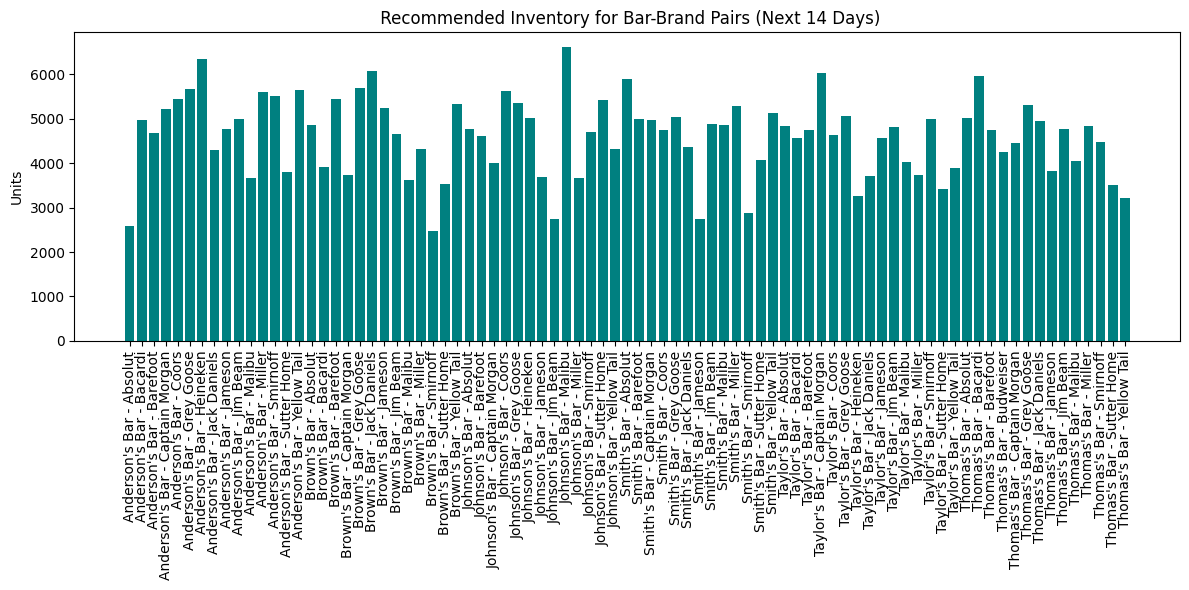

In [10]:
plt.figure(figsize=(12, 6))
plt.bar(recommendations_df['Bar Name'] + " - " + recommendations_df['Brand Name'],
        recommendations_df['Recommended Stock'], color='teal')
plt.xticks(rotation=90)
plt.title(" Recommended Inventory for Bar-Brand Pairs (Next 14 Days)")
plt.ylabel("Units")
plt.tight_layout()
plt.show()

# Export to CSV
recommendations_df.to_csv("inventory_recommendations.csv", index=False)